In [86]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace



import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [87]:
%load_ext autoreload
%autoreload 2



args = arguments()
#boardio is for the the tensorboardx prensetaion and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))

#mnist_train_data, mnist_test_loader  = utils.data(args)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'eval': <built-in function eval>, 'data': 'cifar10', 'model': 'cnn3', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 300, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon_bar': 100, 'optimizer': 'Adam', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': False, 'seed': 0, 'alpha': 100, 'beta': 2, 'gamma': 5, 'max_seconds': 300, 'method_choosing_users': 'fastest ones', 'data_truncation': None, 'choosing_users_verbose': False, 'save_best_model': False, 'privacy': True, 'privacy_choosing_users': True, 'epsilon_sum_deascent_coeff': 0.04, 'delta_f': 0.012, 'device': device(type='cuda'), 'snr_verbose': True, 'max_iterations_alsa': 500, 'ALSA_simulation': False, 'ALSA_verbose': False, 'beta_max_reduction': 30, 'accel_ucb_coeff': 1, 'max_time_alsa': 600, 'pre_ALSA_rounds': 1, 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, 'test_batch_size':

In [88]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC2Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'cifar10':
        global_model = models.CNN3LayerCifar()
    else:
        global_model = models.CNN3LayerMnist()
elif args.model == 'cnn5':
    if args.data == 'mnist' or args.data == 'fashion mnist':
        raise ValueError('CNN5 is not supported for MNIST type datasets')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model = global_model.to(args.device)
print(f"global model's device: {next(global_model.parameters()).device}")

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)





Files already downloaded and verified
Layer (type:depth-idx)                   Param #
CNN3LayerCifar                           --
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            18,496
├─BatchNorm2d: 1-4                       128
├─Conv2d: 1-5                            73,856
├─BatchNorm2d: 1-6                       256
├─MaxPool2d: 1-7                         --
├─Linear: 1-8                            65,664
├─BatchNorm1d: 1-9                       256
├─Linear: 1-10                           8,256
├─BatchNorm1d: 1-11                      128
├─Linear: 1-12                           2,080
├─BatchNorm1d: 1-13                      64
├─Linear: 1-14                           330
├─Dropout: 1-15                          --
├─Dropout: 1-16                          --
├─Dropout: 1-17                          --
Total params: 170,474
Trainable params: 170,474
Non-trainable params: 0
global model's device: cu

In [89]:
# for i in range(100):
#     local_models[0].update_privacy_violation_and_reward()
#     print(f"iteration {i}, next_privacy_term is {local_models[0].next_privacy_term}")

  0%|          | 0/300 [00:00<?, ?it/s]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 1, his deltas theta's mean
 is -0.0009298184886574745,
the empirical var of deltas thetas is 0.003928773105144501
the minimum of the deltas theta is -0.23962588608264923 and the maximum is 0.2577023208141327
the added laplace noise var is 0.003060399989333737
global epoch 1 has been done artifficialy in 0.20 secs, the total time by now is 0.20 
 with avg train loss 2.081, val loss 2.345, avg val acc 10.00%


  0%|          | 1/300 [00:06<31:46,  6.38s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 2, his deltas theta's mean
 is -0.0005331672145985067,
the empirical var of deltas thetas is 0.0034552558790892363
the minimum of the deltas theta is -0.3030347228050232 and the maximum is 0.28664296865463257
the added laplace noise var is 0.0031852972822368235
global epoch 2 has been done artifficialy in 0.12 secs, the total time by now is 0.32 
 with avg train loss 2.036, val loss 2.331, avg val acc 10.00%


  1%|          | 2/300 [00:13<32:26,  6.53s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 3, his deltas theta's mean
 is -0.001884622615762055,
the empirical var of deltas thetas is 0.0030954605899751186
the minimum of the deltas theta is -0.24582955241203308 and the maximum is 0.27423882484436035
the added laplace noise var is 0.0033152917303578187
global epoch 3 has been done artifficialy in 0.14 secs, the total time by now is 0.47 
 with avg train loss 1.984, val loss 2.327, avg val acc 10.00%


  1%|          | 3/300 [00:19<32:04,  6.48s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 4, his deltas theta's mean
 is -0.001473483513109386,
the empirical var of deltas thetas is 0.0028717140667140484
the minimum of the deltas theta is -0.24361959099769592 and the maximum is 0.32210978865623474
the added laplace noise var is 0.0034505913525473436
global epoch 4 has been done artifficialy in 0.14 secs, the total time by now is 0.61 
 with avg train loss 1.985, val loss 2.324, avg val acc 10.00%


  1%|▏         | 4/300 [00:25<31:49,  6.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 5, his deltas theta's mean
 is -0.00038123768172226846,
the empirical var of deltas thetas is 0.0024489867500960827
the minimum of the deltas theta is -0.3205220699310303 and the maximum is 0.32116973400115967
the added laplace noise var is 0.0035914126570663605
global epoch 5 has been done artifficialy in 0.21 secs, the total time by now is 0.82 
 with avg train loss 1.977, val loss 2.324, avg val acc 10.00%


  2%|▏         | 5/300 [00:32<31:38,  6.44s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 6, his deltas theta's mean
 is -0.0004851264238823205,
the empirical var of deltas thetas is 0.002199238631874323
the minimum of the deltas theta is -0.31990185379981995 and the maximum is 0.27165743708610535
the added laplace noise var is 0.0037379809880455804
global epoch 6 has been done artifficialy in 0.17 secs, the total time by now is 1.00 
 with avg train loss 1.951, val loss 2.321, avg val acc 10.00%


  2%|▏         | 6/300 [00:38<31:18,  6.39s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 7, his deltas theta's mean
 is -7.657327660126612e-05,
the empirical var of deltas thetas is 0.0021045806352049112
the minimum of the deltas theta is -0.2583266794681549 and the maximum is 0.2836211919784546
the added laplace noise var is 0.003890530886084149
global epoch 7 has been done artifficialy in 0.09 secs, the total time by now is 1.09 
 with avg train loss 1.955, val loss 2.324, avg val acc 10.00%


  2%|▏         | 7/300 [00:44<31:00,  6.35s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 8, his deltas theta's mean
 is 0.00024652009597048163,
the empirical var of deltas thetas is 0.0017716672737151384
the minimum of the deltas theta is -0.24483799934387207 and the maximum is 0.3007891774177551
the added laplace noise var is 0.0040493064635646414
global epoch 8 has been done artifficialy in 0.14 secs, the total time by now is 1.23 
 with avg train loss 1.932, val loss 2.326, avg val acc 10.00%


  3%|▎         | 8/300 [00:51<30:46,  6.32s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 9, his deltas theta's mean
 is -0.0003147284151054919,
the empirical var of deltas thetas is 0.002059872727841139
the minimum of the deltas theta is -0.24974596500396729 and the maximum is 0.2654536962509155
the added laplace noise var is 0.004214561795284956
global epoch 9 has been done artifficialy in 0.19 secs, the total time by now is 1.41 
 with avg train loss 1.913, val loss 2.315, avg val acc 10.00%


  3%|▎         | 9/300 [00:57<30:30,  6.29s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 10, his deltas theta's mean
 is -0.000858310260809958,
the empirical var of deltas thetas is 0.0019751836080104113
the minimum of the deltas theta is -0.2635870575904846 and the maximum is 0.34476202726364136
the added laplace noise var is 0.004386561325032196
global epoch 10 has been done artifficialy in 0.12 secs, the total time by now is 1.53 
 with avg train loss 1.878, val loss 2.314, avg val acc 10.00%


  3%|▎         | 10/300 [01:03<30:19,  6.27s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 11, his deltas theta's mean
 is -0.0005604397156275809,
the empirical var of deltas thetas is 0.00209045666269958
the minimum of the deltas theta is -0.29881125688552856 and the maximum is 0.3173450529575348
the added laplace noise var is 0.004565580288749148
global epoch 11 has been done artifficialy in 0.10 secs, the total time by now is 1.63 
 with avg train loss 1.863, val loss 2.281, avg val acc 10.00%


  4%|▎         | 11/300 [01:10<31:10,  6.47s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 12, his deltas theta's mean
 is 0.0003286691789980978,
the empirical var of deltas thetas is 0.0018739660736173391
the minimum of the deltas theta is -0.29884374141693115 and the maximum is 0.2414592206478119
the added laplace noise var is 0.004751905154970509
global epoch 12 has been done artifficialy in 0.10 secs, the total time by now is 1.73 
 with avg train loss 1.884, val loss 2.295, avg val acc 10.00%


  4%|▍         | 12/300 [01:16<30:48,  6.42s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 13, his deltas theta's mean
 is -0.00060343585209921,
the empirical var of deltas thetas is 0.0016894943546503782
the minimum of the deltas theta is -0.3564148247241974 and the maximum is 0.32622161507606506
the added laplace noise var is 0.004945834083233656
global epoch 13 has been done artifficialy in 0.11 secs, the total time by now is 1.83 
 with avg train loss 1.851, val loss 2.284, avg val acc 10.00%


  4%|▍         | 13/300 [01:23<30:43,  6.42s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 14, his deltas theta's mean
 is -0.0002507911704014987,
the empirical var of deltas thetas is 0.0019963220693171024
the minimum of the deltas theta is -0.2934727370738983 and the maximum is 0.32325640320777893
the added laplace noise var is 0.005147677401197522
global epoch 14 has been done artifficialy in 0.10 secs, the total time by now is 1.94 
 with avg train loss 1.828, val loss 2.260, avg val acc 10.20%


  5%|▍         | 14/300 [01:29<30:53,  6.48s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 15, his deltas theta's mean
 is 0.0002760056231636554,
the empirical var of deltas thetas is 0.002175017027184367
the minimum of the deltas theta is -0.36247432231903076 and the maximum is 0.41465243697166443
the added laplace noise var is 0.005357758101233054
global epoch 15 has been done artifficialy in 0.14 secs, the total time by now is 2.08 
 with avg train loss 1.821, val loss 2.287, avg val acc 15.13%


  5%|▌         | 15/300 [01:36<30:55,  6.51s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 16, his deltas theta's mean
 is 0.0003969575045630336,
the empirical var of deltas thetas is 0.0018853956134989858
the minimum of the deltas theta is -0.3003966212272644 and the maximum is 0.3138810992240906
the added laplace noise var is 0.005576412357279915
global epoch 16 has been done artifficialy in 0.10 secs, the total time by now is 2.18 
 with avg train loss 1.817, val loss 2.281, avg val acc 12.51%


  5%|▌         | 16/300 [01:43<31:36,  6.68s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 17, his deltas theta's mean
 is -0.0004973282339051366,
the empirical var of deltas thetas is 0.001598516246303916
the minimum of the deltas theta is -0.26743412017822266 and the maximum is 0.3229786157608032
the added laplace noise var is 0.0058039900627965095
global epoch 17 has been done artifficialy in 0.17 secs, the total time by now is 2.35 
 with avg train loss 1.777, val loss 2.177, avg val acc 19.88%


  6%|▌         | 17/300 [01:51<33:11,  7.04s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 18, his deltas theta's mean
 is 0.00013092202425468713,
the empirical var of deltas thetas is 0.0021510724909603596
the minimum of the deltas theta is -0.31726592779159546 and the maximum is 0.3366025686264038
the added laplace noise var is 0.006040855390664162
global epoch 18 has been done artifficialy in 0.15 secs, the total time by now is 2.51 
 with avg train loss 1.780, val loss 2.227, avg val acc 18.81%


  6%|▌         | 18/300 [01:58<33:15,  7.08s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 19, his deltas theta's mean
 is -0.0006958299200050533,
the empirical var of deltas thetas is 0.0020605369936674833
the minimum of the deltas theta is -0.2710314989089966 and the maximum is 0.30342522263526917
the added laplace noise var is 0.006287387375941429
global epoch 19 has been done artifficialy in 0.14 secs, the total time by now is 2.65 
 with avg train loss 1.773, val loss 2.160, avg val acc 16.70%


  6%|▋         | 19/300 [02:05<32:44,  6.99s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 20, his deltas theta's mean
 is -0.0008617562707513571,
the empirical var of deltas thetas is 0.0016776974080130458
the minimum of the deltas theta is -0.22958621382713318 and the maximum is 0.2621925473213196
the added laplace noise var is 0.006543980522401047
global epoch 20 has been done artifficialy in 0.17 secs, the total time by now is 2.82 
 with avg train loss 1.751, val loss 2.179, avg val acc 18.40%


  7%|▋         | 20/300 [02:12<32:19,  6.93s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 21, his deltas theta's mean
 is 0.0007520621875301003,
the empirical var of deltas thetas is 0.001983740832656622
the minimum of the deltas theta is -0.27047625184059143 and the maximum is 0.4381091594696045
the added laplace noise var is 0.006811045433820142
global epoch 21 has been done artifficialy in 0.15 secs, the total time by now is 2.97 
 with avg train loss 1.751, val loss 2.236, avg val acc 15.02%


  7%|▋         | 21/300 [02:18<31:43,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 22, his deltas theta's mean
 is -0.00017608121561352164,
the empirical var of deltas thetas is 0.0018484563333913684
the minimum of the deltas theta is -0.23463553190231323 and the maximum is 0.3612184524536133
the added laplace noise var is 0.007089009471033874
global epoch 22 has been done artifficialy in 0.19 secs, the total time by now is 3.16 
 with avg train loss 1.722, val loss 2.106, avg val acc 17.52%


  7%|▋         | 22/300 [02:25<31:11,  6.73s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 23, his deltas theta's mean
 is -0.0008426703279837966,
the empirical var of deltas thetas is 0.002115258714184165
the minimum of the deltas theta is -0.24313174188137054 and the maximum is 0.3479856550693512
the added laplace noise var is 0.0073783174358039395
global epoch 23 has been done artifficialy in 0.19 secs, the total time by now is 3.34 
 with avg train loss 1.715, val loss 2.069, avg val acc 20.23%


  8%|▊         | 23/300 [02:32<31:55,  6.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 24, his deltas theta's mean
 is -0.0011387236882001162,
the empirical var of deltas thetas is 0.0023436015471816063
the minimum of the deltas theta is -0.302663654088974 and the maximum is 0.34817343950271606
the added laplace noise var is 0.007679432282596293
global epoch 24 has been done artifficialy in 0.15 secs, the total time by now is 3.49 
 with avg train loss 1.694, val loss 2.021, avg val acc 21.83%


  8%|▊         | 24/300 [02:39<32:01,  6.96s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 25, his deltas theta's mean
 is 0.00017520581604912877,
the empirical var of deltas thetas is 0.002025005640462041
the minimum of the deltas theta is -0.3131731450557709 and the maximum is 0.31218037009239197
the added laplace noise var is 0.007992835859407068
global epoch 25 has been done artifficialy in 0.16 secs, the total time by now is 3.64 
 with avg train loss 1.718, val loss 2.063, avg val acc 20.27%


  8%|▊         | 25/300 [02:46<31:28,  6.87s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 26, his deltas theta's mean
 is 0.0002833257894963026,
the empirical var of deltas thetas is 0.0022311771754175425
the minimum of the deltas theta is -0.2914455235004425 and the maximum is 0.3099878132343292
the added laplace noise var is 0.008319029678822153
global epoch 26 has been done artifficialy in 0.17 secs, the total time by now is 3.82 
 with avg train loss 1.672, val loss 1.936, avg val acc 24.77%


  9%|▊         | 26/300 [02:52<31:07,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 27, his deltas theta's mean
 is -0.0007354978588409722,
the empirical var of deltas thetas is 0.002610014518722892
the minimum of the deltas theta is -0.37301942706108093 and the maximum is 0.38650766015052795
the added laplace noise var is 0.008658535720544341
global epoch 27 has been done artifficialy in 0.10 secs, the total time by now is 3.91 
 with avg train loss 1.685, val loss 1.936, avg val acc 27.38%


  9%|▉         | 27/300 [02:59<30:47,  6.77s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 28, his deltas theta's mean
 is -0.0002989627537317574,
the empirical var of deltas thetas is 0.002072828821837902
the minimum of the deltas theta is -0.2874315083026886 and the maximum is 0.3323001563549042
the added laplace noise var is 0.009011897266672203
global epoch 28 has been done artifficialy in 0.11 secs, the total time by now is 4.02 
 with avg train loss 1.657, val loss 1.867, avg val acc 31.26%


  9%|▉         | 28/300 [03:06<31:30,  6.95s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 29, his deltas theta's mean
 is 0.00017056718934327364,
the empirical var of deltas thetas is 0.0019502947106957436
the minimum of the deltas theta is -0.29848870635032654 and the maximum is 0.31027841567993164
the added laplace noise var is 0.009379679771067361
global epoch 29 has been done artifficialy in 0.22 secs, the total time by now is 4.24 
 with avg train loss 1.645, val loss 1.865, avg val acc 29.24%


 10%|▉         | 29/300 [03:13<31:25,  6.96s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 30, his deltas theta's mean
 is -0.0010240081464871764,
the empirical var of deltas thetas is 0.002419791417196393
the minimum of the deltas theta is -0.34005558490753174 and the maximum is 0.32580578327178955
the added laplace noise var is 0.009762471764201303
global epoch 30 has been done artifficialy in 0.14 secs, the total time by now is 4.38 
 with avg train loss 1.637, val loss 1.849, avg val acc 32.18%


 10%|█         | 30/300 [03:20<31:05,  6.91s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 31, his deltas theta's mean
 is -0.0011154268868267536,
the empirical var of deltas thetas is 0.002277280203998089
the minimum of the deltas theta is -0.320052832365036 and the maximum is 0.3532344102859497
the added laplace noise var is 0.010160885794929691
global epoch 31 has been done artifficialy in 0.16 secs, the total time by now is 4.53 
 with avg train loss 1.629, val loss 1.794, avg val acc 35.10%


 10%|█         | 31/300 [03:27<30:42,  6.85s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 32, his deltas theta's mean
 is -0.0020176449324935675,
the empirical var of deltas thetas is 0.0023471203166991472
the minimum of the deltas theta is -0.3167598843574524 and the maximum is 0.3749035596847534
the added laplace noise var is 0.01057555941070121
global epoch 32 has been done artifficialy in 0.13 secs, the total time by now is 4.66 
 with avg train loss 1.610, val loss 1.801, avg val acc 31.99%


 11%|█         | 32/300 [03:34<30:29,  6.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 33, his deltas theta's mean
 is 0.0004962054081261158,
the empirical var of deltas thetas is 0.002496647648513317
the minimum of the deltas theta is -0.331734299659729 and the maximum is 0.3919735550880432
the added laplace noise var is 0.011007156177769524
global epoch 33 has been done artifficialy in 0.17 secs, the total time by now is 4.83 
 with avg train loss 1.611, val loss 1.799, avg val acc 32.83%


 11%|█         | 33/300 [03:41<30:22,  6.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 34, his deltas theta's mean
 is -0.0003262785030528903,
the empirical var of deltas thetas is 0.003015556139871478
the minimum of the deltas theta is -0.3827575445175171 and the maximum is 0.38957008719444275
the added laplace noise var is 0.011456366743040828
global epoch 34 has been done artifficialy in 0.15 secs, the total time by now is 4.98 
 with avg train loss 1.575, val loss 1.737, avg val acc 36.01%


 11%|█▏        | 34/300 [03:48<30:35,  6.90s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 35, his deltas theta's mean
 is -0.0005461269174702466,
the empirical var of deltas thetas is 0.002462865551933646
the minimum of the deltas theta is -0.33224010467529297 and the maximum is 0.3958812952041626
the added laplace noise var is 0.011923909939256253
global epoch 35 has been done artifficialy in 0.12 secs, the total time by now is 5.10 
 with avg train loss 1.594, val loss 1.823, avg val acc 33.15%


 12%|█▏        | 35/300 [03:55<31:41,  7.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 36, his deltas theta's mean
 is -0.000700971286278218,
the empirical var of deltas thetas is 0.002192448126152158
the minimum of the deltas theta is -0.29369837045669556 and the maximum is 0.38347211480140686
the added laplace noise var is 0.012410533935277612
global epoch 36 has been done artifficialy in 0.10 secs, the total time by now is 5.20 
 with avg train loss 1.580, val loss 1.746, avg val acc 35.42%


 12%|█▏        | 36/300 [04:03<31:30,  7.16s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 37, his deltas theta's mean
 is -0.0008838362991809845,
the empirical var of deltas thetas is 0.002620340557768941
the minimum of the deltas theta is -0.2946093678474426 and the maximum is 0.35091206431388855
the added laplace noise var is 0.012917017433317197
global epoch 37 has been done artifficialy in 0.13 secs, the total time by now is 5.33 
 with avg train loss 1.561, val loss 1.799, avg val acc 33.75%


 12%|█▏        | 37/300 [04:10<31:09,  7.11s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 38, his deltas theta's mean
 is -0.0009495686390437186,
the empirical var of deltas thetas is 0.0023194111417979
the minimum of the deltas theta is -0.2591031789779663 and the maximum is 0.3422831892967224
the added laplace noise var is 0.01344417091502745
global epoch 38 has been done artifficialy in 0.18 secs, the total time by now is 5.51 
 with avg train loss 1.550, val loss 1.675, avg val acc 39.88%


 13%|█▎        | 38/300 [04:16<29:44,  6.81s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 39, his deltas theta's mean
 is -0.0010197684168815613,
the empirical var of deltas thetas is 0.0027593837585300207
the minimum of the deltas theta is -0.31710076332092285 and the maximum is 0.3258245587348938
the added laplace noise var is 0.013992837938444509
global epoch 39 has been done artifficialy in 0.13 secs, the total time by now is 5.63 
 with avg train loss 1.558, val loss 1.686, avg val acc 39.41%


 13%|█▎        | 39/300 [04:22<28:36,  6.58s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 40, his deltas theta's mean
 is -0.0006871088407933712,
the empirical var of deltas thetas is 0.0027006040327250957
the minimum of the deltas theta is -0.3040684163570404 and the maximum is 0.36310380697250366
the added laplace noise var is 0.014563896487861052
global epoch 40 has been done artifficialy in 0.20 secs, the total time by now is 5.83 
 with avg train loss 1.536, val loss 1.609, avg val acc 41.59%


 13%|█▎        | 40/300 [04:28<27:45,  6.41s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 41, his deltas theta's mean
 is 6.41013002677937e-06,
the empirical var of deltas thetas is 0.002653644420206547
the minimum of the deltas theta is -0.3327816426753998 and the maximum is 0.37405097484588623
the added laplace noise var is 0.015158260378788464
global epoch 41 has been done artifficialy in 0.13 secs, the total time by now is 5.97 
 with avg train loss 1.537, val loss 1.596, avg val acc 43.91%


 14%|█▎        | 41/300 [04:34<27:04,  6.27s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 42, his deltas theta's mean
 is 0.00023015793703962117,
the empirical var of deltas thetas is 0.0027561781462281942
the minimum of the deltas theta is -0.37344425916671753 and the maximum is 0.36927366256713867
the added laplace noise var is 0.015776880720256625
global epoch 42 has been done artifficialy in 0.10 secs, the total time by now is 6.07 
 with avg train loss 1.532, val loss 1.646, avg val acc 41.75%


 14%|█▍        | 42/300 [04:40<26:34,  6.18s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 43, his deltas theta's mean
 is -0.00015850829367991537,
the empirical var of deltas thetas is 0.002968133194372058
the minimum of the deltas theta is -0.30338066816329956 and the maximum is 0.3506544530391693
the added laplace noise var is 0.016420747436791262
global epoch 43 has been done artifficialy in 0.12 secs, the total time by now is 6.19 
 with avg train loss 1.505, val loss 1.596, avg val acc 43.36%


 14%|█▍        | 43/300 [04:46<26:12,  6.12s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 44, his deltas theta's mean
 is 5.555568714044057e-05,
the empirical var of deltas thetas is 0.0023629467468708754
the minimum of the deltas theta is -0.2836916744709015 and the maximum is 0.3396052420139313
the added laplace noise var is 0.017090890852504384
global epoch 44 has been done artifficialy in 0.20 secs, the total time by now is 6.39 
 with avg train loss 1.512, val loss 1.553, avg val acc 45.58%


 15%|█▍        | 44/300 [04:53<27:08,  6.36s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 45, his deltas theta's mean
 is -0.0018075782572850585,
the empirical var of deltas thetas is 0.0033902667928487062
the minimum of the deltas theta is -0.5902746319770813 and the maximum is 0.4747505187988281
the added laplace noise var is 0.017788383339832698
global epoch 45 has been done artifficialy in 0.11 secs, the total time by now is 6.51 
 with avg train loss 1.496, val loss 1.572, avg val acc 45.50%


 15%|█▌        | 45/300 [04:59<27:49,  6.55s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 46, his deltas theta's mean
 is 0.0002907215675804764,
the empirical var of deltas thetas is 0.002647233195602894
the minimum of the deltas theta is -0.27857506275177 and the maximum is 0.47381818294525146
the added laplace noise var is 0.01851434103556225
global epoch 46 has been done artifficialy in 0.09 secs, the total time by now is 6.60 
 with avg train loss 1.488, val loss 1.571, avg val acc 44.75%


 15%|█▌        | 46/300 [05:07<28:24,  6.71s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 47, his deltas theta's mean
 is -0.0009428229532204568,
the empirical var of deltas thetas is 0.00275834696367383
the minimum of the deltas theta is -0.3319947123527527 and the maximum is 0.32491523027420044
the added laplace noise var is 0.019269925626885447
global epoch 47 has been done artifficialy in 0.11 secs, the total time by now is 6.71 
 with avg train loss 1.503, val loss 1.557, avg val acc 46.39%


 16%|█▌        | 47/300 [05:14<28:59,  6.87s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 48, his deltas theta's mean
 is -0.0013298962730914354,
the empirical var of deltas thetas is 0.0031424122862517834
the minimum of the deltas theta is -0.6769034266471863 and the maximum is 0.40124380588531494
the added laplace noise var is 0.02005634621034838
global epoch 48 has been done artifficialy in 0.14 secs, the total time by now is 6.85 
 with avg train loss 1.494, val loss 1.588, avg val acc 41.87%


 16%|█▌        | 48/300 [05:21<29:21,  6.99s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 49, his deltas theta's mean
 is -0.00013344715989660472,
the empirical var of deltas thetas is 0.0029818518087267876
the minimum of the deltas theta is -0.26778581738471985 and the maximum is 0.3759128153324127
the added laplace noise var is 0.02087486122666327
global epoch 49 has been done artifficialy in 0.08 secs, the total time by now is 6.94 
 with avg train loss 1.475, val loss 1.602, avg val acc 42.68%


 16%|█▋        | 49/300 [05:28<29:08,  6.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 50, his deltas theta's mean
 is -0.0013991731684654951,
the empirical var of deltas thetas is 0.003519466845318675
the minimum of the deltas theta is -0.40982985496520996 and the maximum is 0.3693201243877411
the added laplace noise var is 0.021726780474482066
global epoch 50 has been done artifficialy in 0.13 secs, the total time by now is 7.07 
 with avg train loss 1.472, val loss 1.598, avg val acc 44.02%


 17%|█▋        | 50/300 [05:35<29:07,  6.99s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 51, his deltas theta's mean
 is -0.0021044998429715633,
the empirical var of deltas thetas is 0.0030050526838749647
the minimum of the deltas theta is -0.40686100721359253 and the maximum is 0.3759276568889618
the added laplace noise var is 0.022613467206353745
global epoch 51 has been done artifficialy in 0.13 secs, the total time by now is 7.21 
 with avg train loss 1.464, val loss 1.565, avg val acc 45.11%


 17%|█▋        | 51/300 [05:42<29:22,  7.08s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 52, his deltas theta's mean
 is -0.002159906318411231,
the empirical var of deltas thetas is 0.0031350685749202967
the minimum of the deltas theta is -0.3309759199619293 and the maximum is 0.4406200051307678
the added laplace noise var is 0.023536340310219228
global epoch 52 has been done artifficialy in 0.13 secs, the total time by now is 7.34 
 with avg train loss 1.462, val loss 1.521, avg val acc 45.28%


 17%|█▋        | 52/300 [05:50<29:29,  7.13s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 53, his deltas theta's mean
 is -0.000863809953443706,
the empirical var of deltas thetas is 0.0034098855685442686
the minimum of the deltas theta is -0.3385820984840393 and the maximum is 0.42552274465560913
the added laplace noise var is 0.02449687657993479
global epoch 53 has been done artifficialy in 0.09 secs, the total time by now is 7.43 
 with avg train loss 1.473, val loss 1.599, avg val acc 43.24%


 18%|█▊        | 53/300 [05:57<29:11,  7.09s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 54, his deltas theta's mean
 is -0.0017506064614281058,
the empirical var of deltas thetas is 0.0031568179838359356
the minimum of the deltas theta is -0.29446297883987427 and the maximum is 0.3600083887577057
the added laplace noise var is 0.025496613078457308
global epoch 54 has been done artifficialy in 0.10 secs, the total time by now is 7.53 
 with avg train loss 1.439, val loss 1.476, avg val acc 47.87%


 18%|█▊        | 54/300 [06:04<28:57,  7.06s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 55, his deltas theta's mean
 is -0.0015469193458557129,
the empirical var of deltas thetas is 0.003046718891710043
the minimum of the deltas theta is -0.3640800416469574 and the maximum is 0.44279801845550537
the added laplace noise var is 0.026537149597472925
global epoch 55 has been done artifficialy in 0.18 secs, the total time by now is 7.71 
 with avg train loss 1.436, val loss 1.496, avg val acc 46.45%


 18%|█▊        | 55/300 [06:10<28:16,  6.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 56, his deltas theta's mean
 is -0.0018897876143455505,
the empirical var of deltas thetas is 0.004122691694647074
the minimum of the deltas theta is -0.43504008650779724 and the maximum is 0.4909780025482178
the added laplace noise var is 0.02762015121740502
global epoch 56 has been done artifficialy in 0.20 secs, the total time by now is 7.91 
 with avg train loss 1.477, val loss 1.608, avg val acc 41.39%


 19%|█▊        | 56/300 [06:17<28:03,  6.90s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 57, his deltas theta's mean
 is -0.0012742145918309689,
the empirical var of deltas thetas is 0.0033892958890646696
the minimum of the deltas theta is -0.43895071744918823 and the maximum is 0.4309135675430298
the added laplace noise var is 0.028747350971898154
global epoch 57 has been done artifficialy in 0.17 secs, the total time by now is 8.08 
 with avg train loss 1.425, val loss 1.463, avg val acc 47.44%


 19%|█▉        | 57/300 [06:24<27:50,  6.87s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 58, his deltas theta's mean
 is -0.002147289225831628,
the empirical var of deltas thetas is 0.004094185773283243
the minimum of the deltas theta is -0.4918992519378662 and the maximum is 0.43259724974632263
the added laplace noise var is 0.02992055262104161
global epoch 58 has been done artifficialy in 0.17 secs, the total time by now is 8.24 
 with avg train loss 1.438, val loss 1.538, avg val acc 44.65%


 19%|█▉        | 58/300 [06:31<27:30,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 59, his deltas theta's mean
 is -0.0009708629222586751,
the empirical var of deltas thetas is 0.0037024482153356075
the minimum of the deltas theta is -0.42869192361831665 and the maximum is 0.514582097530365
the added laplace noise var is 0.031141633537770413
global epoch 59 has been done artifficialy in 0.20 secs, the total time by now is 8.44 
 with avg train loss 1.416, val loss 1.497, avg val acc 46.36%


 20%|█▉        | 59/300 [06:37<27:18,  6.80s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 60, his deltas theta's mean
 is -0.000790438090916723,
the empirical var of deltas thetas is 0.0031604990363121033
the minimum of the deltas theta is -0.3641190230846405 and the maximum is 0.4257761836051941
the added laplace noise var is 0.032412547712062464
global epoch 60 has been done artifficialy in 0.12 secs, the total time by now is 8.56 
 with avg train loss 1.416, val loss 1.432, avg val acc 49.07%


 20%|██        | 60/300 [06:44<27:15,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 61, his deltas theta's mean
 is -0.0012546423822641373,
the empirical var of deltas thetas is 0.003420622553676367
the minimum of the deltas theta is -0.3409085273742676 and the maximum is 0.3307410478591919
the added laplace noise var is 0.03373532887773946
global epoch 61 has been done artifficialy in 0.15 secs, the total time by now is 8.71 
 with avg train loss 1.433, val loss 1.451, avg val acc 47.92%


 20%|██        | 61/300 [06:51<27:13,  6.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 62, his deltas theta's mean
 is -0.001822320045903325,
the empirical var of deltas thetas is 0.003179361345246434
the minimum of the deltas theta is -0.355258047580719 and the maximum is 0.3674469590187073
the added laplace noise var is 0.03511209376687483
global epoch 62 has been done artifficialy in 0.12 secs, the total time by now is 8.83 
 with avg train loss 1.399, val loss 1.445, avg val acc 47.78%


 21%|██        | 62/300 [06:58<27:31,  6.94s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 63, his deltas theta's mean
 is -0.0023072154726833105,
the empirical var of deltas thetas is 0.0035966760478913784
the minimum of the deltas theta is -0.4841301739215851 and the maximum is 0.3741148114204407
the added laplace noise var is 0.036545045497016725
global epoch 63 has been done artifficialy in 0.12 secs, the total time by now is 8.96 
 with avg train loss 1.384, val loss 1.460, avg val acc 46.74%


 21%|██        | 63/300 [07:05<27:32,  6.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 64, his deltas theta's mean
 is -0.002426409162580967,
the empirical var of deltas thetas is 0.003836639691144228
the minimum of the deltas theta is -0.3331967890262604 and the maximum is 0.40219396352767944
the added laplace noise var is 0.03803647709664604
global epoch 64 has been done artifficialy in 0.09 secs, the total time by now is 9.05 
 with avg train loss 1.390, val loss 1.374, avg val acc 51.32%


 21%|██▏       | 64/300 [07:12<27:12,  6.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 65, his deltas theta's mean
 is -0.0006777889211662114,
the empirical var of deltas thetas is 0.0035553346388041973
the minimum of the deltas theta is -0.3813754618167877 and the maximum is 0.45441100001335144
the added laplace noise var is 0.039588775174511204
global epoch 65 has been done artifficialy in 0.09 secs, the total time by now is 9.15 
 with avg train loss 1.377, val loss 1.420, avg val acc 50.21%


 22%|██▏       | 65/300 [07:18<26:08,  6.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 66, his deltas theta's mean
 is 0.0002275739097967744,
the empirical var of deltas thetas is 0.003531740279868245
the minimum of the deltas theta is -0.33667126297950745 and the maximum is 0.4396519958972931
the added laplace noise var is 0.0412044237387114
global epoch 66 has been done artifficialy in 0.19 secs, the total time by now is 9.34 
 with avg train loss 1.388, val loss 1.430, avg val acc 47.72%


 22%|██▏       | 66/300 [07:24<25:14,  6.47s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 67, his deltas theta's mean
 is -0.0002440443931845948,
the empirical var of deltas thetas is 0.004096130840480328
the minimum of the deltas theta is -0.3768988847732544 and the maximum is 0.46980807185173035
the added laplace noise var is 0.042886008171639435
global epoch 67 has been done artifficialy in 0.12 secs, the total time by now is 9.46 
 with avg train loss 1.380, val loss 1.433, avg val acc 46.52%


 22%|██▏       | 67/300 [07:30<24:32,  6.32s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 68, his deltas theta's mean
 is -0.0002467138401698321,
the empirical var of deltas thetas is 0.0037920919712632895
the minimum of the deltas theta is -0.3398228883743286 and the maximum is 0.43048980832099915
the added laplace noise var is 0.04463621936714514
global epoch 68 has been done artifficialy in 0.18 secs, the total time by now is 9.64 
 with avg train loss 1.382, val loss 1.400, avg val acc 49.91%


 23%|██▎       | 68/300 [07:36<24:01,  6.21s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 69, his deltas theta's mean
 is -0.001013644621707499,
the empirical var of deltas thetas is 0.003609614446759224
the minimum of the deltas theta is -0.3172205686569214 and the maximum is 0.3418709933757782
the added laplace noise var is 0.0464578580365396
global epoch 69 has been done artifficialy in 0.11 secs, the total time by now is 9.75 
 with avg train loss 1.371, val loss 1.424, avg val acc 49.75%


 23%|██▎       | 69/300 [07:42<23:35,  6.13s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 70, his deltas theta's mean
 is -0.0010870133992284536,
the empirical var of deltas thetas is 0.005203539039939642
the minimum of the deltas theta is -0.3951759934425354 and the maximum is 0.4691559076309204
the added laplace noise var is 0.04835383919033085
global epoch 70 has been done artifficialy in 0.12 secs, the total time by now is 9.87 
 with avg train loss 1.365, val loss 1.440, avg val acc 47.55%


 23%|██▎       | 70/300 [07:48<23:19,  6.08s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 71, his deltas theta's mean
 is -0.0011736989254131913,
the empirical var of deltas thetas is 0.004686245694756508
the minimum of the deltas theta is -0.37535250186920166 and the maximum is 0.4263370633125305
the added laplace noise var is 0.050327196802862476
global epoch 71 has been done artifficialy in 0.15 secs, the total time by now is 10.02 
 with avg train loss 1.392, val loss 1.447, avg val acc 49.58%


 24%|██▎       | 71/300 [07:55<24:19,  6.37s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 72, his deltas theta's mean
 is -0.0010954992612823844,
the empirical var of deltas thetas is 0.00392327643930912
the minimum of the deltas theta is -0.3311008810997009 and the maximum is 0.383360892534256
the added laplace noise var is 0.05238108866731998
global epoch 72 has been done artifficialy in 0.13 secs, the total time by now is 10.15 
 with avg train loss 1.361, val loss 1.404, avg val acc 50.10%


 24%|██▍       | 72/300 [08:01<23:53,  6.29s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 73, his deltas theta's mean
 is -0.00023259062436409295,
the empirical var of deltas thetas is 0.004971830174326897
the minimum of the deltas theta is -0.4063571095466614 and the maximum is 0.5225918292999268
the added laplace noise var is 0.054518801448873444
global epoch 73 has been done artifficialy in 0.13 secs, the total time by now is 10.28 
 with avg train loss 1.365, val loss 1.405, avg val acc 49.62%


 24%|██▍       | 73/300 [08:07<23:29,  6.21s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 74, his deltas theta's mean
 is -0.0004446274833753705,
the empirical var of deltas thetas is 0.004031664226204157
the minimum of the deltas theta is -0.34057706594467163 and the maximum is 0.4647144079208374
the added laplace noise var is 0.05674375594404307
global epoch 74 has been done artifficialy in 0.08 secs, the total time by now is 10.36 
 with avg train loss 1.360, val loss 1.427, avg val acc 48.07%


 25%|██▍       | 74/300 [08:13<23:14,  6.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 75, his deltas theta's mean
 is -0.0022231596522033215,
the empirical var of deltas thetas is 0.004138742573559284
the minimum of the deltas theta is -0.37307387590408325 and the maximum is 0.38188493251800537
the added laplace noise var is 0.0590595125547034
global epoch 75 has been done artifficialy in 0.12 secs, the total time by now is 10.48 
 with avg train loss 1.386, val loss 1.423, avg val acc 50.01%


 25%|██▌       | 75/300 [08:19<23:08,  6.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 76, his deltas theta's mean
 is -0.0012071343371644616,
the empirical var of deltas thetas is 0.003945931792259216
the minimum of the deltas theta is -0.3528386950492859 and the maximum is 0.4554310739040375
the added laplace noise var is 0.061469776985485926
global epoch 76 has been done artifficialy in 0.14 secs, the total time by now is 10.62 
 with avg train loss 1.346, val loss 1.429, avg val acc 49.88%


 25%|██▌       | 76/300 [08:26<23:00,  6.16s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 77, his deltas theta's mean
 is -0.0009038840653374791,
the empirical var of deltas thetas is 0.004191789776086807
the minimum of the deltas theta is -0.34766626358032227 and the maximum is 0.34656205773353577
the added laplace noise var is 0.06397840617369704
global epoch 77 has been done artifficialy in 0.10 secs, the total time by now is 10.72 
 with avg train loss 1.370, val loss 1.503, avg val acc 47.35%


 26%|██▌       | 77/300 [08:32<22:45,  6.12s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 78, his deltas theta's mean
 is -0.002707999898120761,
the empirical var of deltas thetas is 0.0040144831873476505
the minimum of the deltas theta is -0.3541073799133301 and the maximum is 0.41748854517936707
the added laplace noise var is 0.0665894144612407
global epoch 78 has been done artifficialy in 0.17 secs, the total time by now is 10.90 
 with avg train loss 1.369, val loss 1.491, avg val acc 48.77%


 26%|██▌       | 78/300 [08:38<23:09,  6.26s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 79, his deltas theta's mean
 is -0.0005723422509618104,
the empirical var of deltas thetas is 0.004452844150364399
the minimum of the deltas theta is -0.47334688901901245 and the maximum is 0.38158440589904785
the added laplace noise var is 0.06930698001842174
global epoch 79 has been done artifficialy in 0.09 secs, the total time by now is 10.98 
 with avg train loss 1.353, val loss 1.489, avg val acc 47.97%


 26%|██▋       | 79/300 [08:45<23:44,  6.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 80, his deltas theta's mean
 is -0.001604713499546051,
the empirical var of deltas thetas is 0.004176870919764042
the minimum of the deltas theta is -0.3831028938293457 and the maximum is 0.3456101417541504
the added laplace noise var is 0.07213545152990992
global epoch 80 has been done artifficialy in 0.16 secs, the total time by now is 11.15 
 with avg train loss 1.368, val loss 1.472, avg val acc 48.69%


 27%|██▋       | 80/300 [08:52<24:05,  6.57s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 81, his deltas theta's mean
 is -0.0022126948460936546,
the empirical var of deltas thetas is 0.004901362583041191
the minimum of the deltas theta is -0.42646148800849915 and the maximum is 0.436662495136261
the added laplace noise var is 0.07507935515356305
global epoch 81 has been done artifficialy in 0.12 secs, the total time by now is 11.27 
 with avg train loss 1.355, val loss 1.448, avg val acc 49.25%


 27%|██▋       | 81/300 [08:59<24:16,  6.65s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 82, his deltas theta's mean
 is -0.0006459610885940492,
the empirical var of deltas thetas is 0.004244775045663118
the minimum of the deltas theta is -0.3464939594268799 and the maximum is 0.3579885959625244
the added laplace noise var is 0.07814340176324523
global epoch 82 has been done artifficialy in 0.11 secs, the total time by now is 11.38 
 with avg train loss 1.369, val loss 1.463, avg val acc 48.58%


 27%|██▋       | 82/300 [09:06<24:27,  6.73s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 83, his deltas theta's mean
 is -0.0007222509593702853,
the empirical var of deltas thetas is 0.005098109599202871
the minimum of the deltas theta is -0.48034435510635376 and the maximum is 0.4229140281677246
the added laplace noise var is 0.08133249448723011
global epoch 83 has been done artifficialy in 0.19 secs, the total time by now is 11.56 
 with avg train loss 1.357, val loss 1.506, avg val acc 47.02%


 28%|██▊       | 83/300 [09:13<24:30,  6.78s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 84, his deltas theta's mean
 is -0.00036509314668364823,
the empirical var of deltas thetas is 0.004056598991155624
the minimum of the deltas theta is -0.43002864718437195 and the maximum is 0.36747807264328003
the added laplace noise var is 0.08465173655425208
global epoch 84 has been done artifficialy in 0.19 secs, the total time by now is 11.75 
 with avg train loss 1.373, val loss 1.479, avg val acc 46.95%


 28%|██▊       | 84/300 [09:19<24:30,  6.81s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 85, his deltas theta's mean
 is -0.0014292695559561253,
the empirical var of deltas thetas is 0.004373160190880299
the minimum of the deltas theta is -0.3546940088272095 and the maximum is 0.39344245195388794
the added laplace noise var is 0.0881064394597612
global epoch 85 has been done artifficialy in 0.11 secs, the total time by now is 11.86 
 with avg train loss 1.370, val loss 1.528, avg val acc 45.35%


 28%|██▊       | 85/300 [09:26<24:25,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 86, his deltas theta's mean
 is -0.0011337018804624677,
the empirical var of deltas thetas is 0.005456102546304464
the minimum of the deltas theta is -0.42277899384498596 and the maximum is 0.49218636751174927
the added laplace noise var is 0.09170213146544885
global epoch 86 has been done artifficialy in 0.12 secs, the total time by now is 11.97 
 with avg train loss 1.362, val loss 1.595, avg val acc 42.74%


 29%|██▊       | 86/300 [09:33<24:18,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 87, his deltas theta's mean
 is -0.0008298000320792198,
the empirical var of deltas thetas is 0.004844448063522577
the minimum of the deltas theta is -0.4320870041847229 and the maximum is 0.4431774914264679
the added laplace noise var is 0.09544456644564597
global epoch 87 has been done artifficialy in 0.12 secs, the total time by now is 12.10 
 with avg train loss 1.369, val loss 1.721, avg val acc 37.91%


 29%|██▉       | 87/300 [09:40<24:10,  6.81s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 88, his deltas theta's mean
 is -0.0004855777369812131,
the empirical var of deltas thetas is 0.004935297649353743
the minimum of the deltas theta is -0.45808231830596924 and the maximum is 0.44560661911964417
the added laplace noise var is 0.09933973309474964
global epoch 88 has been done artifficialy in 0.13 secs, the total time by now is 12.23 
 with avg train loss 1.400, val loss 1.548, avg val acc 45.54%


 29%|██▉       | 88/300 [09:47<24:05,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 89, his deltas theta's mean
 is -0.0024130861274898052,
the empirical var of deltas thetas is 0.0051547870971262455
the minimum of the deltas theta is -0.4647933542728424 and the maximum is 0.4174003303050995
the added laplace noise var is 0.10339386451041159
global epoch 89 has been done artifficialy in 0.14 secs, the total time by now is 12.37 
 with avg train loss 1.394, val loss 1.541, avg val acc 45.39%


 30%|██▉       | 89/300 [09:54<23:58,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 90, his deltas theta's mean
 is -0.001855032634921372,
the empirical var of deltas thetas is 0.006106487940996885
the minimum of the deltas theta is -0.4286140203475952 and the maximum is 0.3997783362865448
the added laplace noise var is 0.10761344816782437
global epoch 90 has been done artifficialy in 0.09 secs, the total time by now is 12.47 
 with avg train loss 1.417, val loss 1.596, avg val acc 44.03%


 30%|███       | 90/300 [10:00<23:51,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 91, his deltas theta's mean
 is -0.00012591011181939393,
the empirical var of deltas thetas is 0.01751522347331047
the minimum of the deltas theta is -0.515370786190033 and the maximum is 0.5068625807762146
the added laplace noise var is 0.11200523630106572
global epoch 91 has been done artifficialy in 0.12 secs, the total time by now is 12.58 
 with avg train loss 1.449, val loss 1.692, avg val acc 37.80%


 30%|███       | 91/300 [10:07<23:46,  6.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 92, his deltas theta's mean
 is -0.001873016357421875,
the empirical var of deltas thetas is 0.004453423898667097
the minimum of the deltas theta is -0.3503400385379791 and the maximum is 0.4050306975841522
the added laplace noise var is 0.1165762567081136
global epoch 92 has been done artifficialy in 0.16 secs, the total time by now is 12.74 
 with avg train loss 1.421, val loss 1.612, avg val acc 42.57%


 31%|███       | 92/300 [10:14<23:39,  6.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 93, his deltas theta's mean
 is -0.001563799800351262,
the empirical var of deltas thetas is 0.004310848657041788
the minimum of the deltas theta is -0.45518970489501953 and the maximum is 0.44290292263031006
the added laplace noise var is 0.12133382399682234
global epoch 93 has been done artifficialy in 0.10 secs, the total time by now is 12.84 
 with avg train loss 1.383, val loss 1.588, avg val acc 42.84%


 31%|███       | 93/300 [10:21<23:35,  6.84s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 94, his deltas theta's mean
 is -0.000342998537234962,
the empirical var of deltas thetas is 0.003823551582172513
the minimum of the deltas theta is -0.3771759271621704 and the maximum is 0.4370178282260895
the added laplace noise var is 0.1262855512898556
global epoch 94 has been done artifficialy in 0.18 secs, the total time by now is 13.02 
 with avg train loss 1.426, val loss 1.628, avg val acc 41.61%


 31%|███▏      | 94/300 [10:28<23:44,  6.91s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 95, his deltas theta's mean
 is -4.6219003706937656e-05,
the empirical var of deltas thetas is 0.004008433781564236
the minimum of the deltas theta is -0.418407678604126 and the maximum is 0.3805803060531616
the added laplace noise var is 0.1314393624073072
global epoch 95 has been done artifficialy in 0.19 secs, the total time by now is 13.21 
 with avg train loss 1.433, val loss 1.672, avg val acc 40.75%


 32%|███▏      | 95/300 [10:35<23:47,  6.96s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 96, his deltas theta's mean
 is -0.0008059613173827529,
the empirical var of deltas thetas is 0.004524513613432646
the minimum of the deltas theta is -0.3745462894439697 and the maximum is 0.46387726068496704
the added laplace noise var is 0.13680350454650322
global epoch 96 has been done artifficialy in 0.15 secs, the total time by now is 13.36 
 with avg train loss 1.457, val loss 1.722, avg val acc 40.35%


 32%|███▏      | 96/300 [10:42<23:47,  7.00s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 97, his deltas theta's mean
 is -0.0006254160543903708,
the empirical var of deltas thetas is 0.004438790027052164
the minimum of the deltas theta is -0.42268913984298706 and the maximum is 0.41086268424987793
the added laplace noise var is 0.14238656147927792
global epoch 97 has been done artifficialy in 0.14 secs, the total time by now is 13.50 
 with avg train loss 1.435, val loss 1.660, avg val acc 40.98%


 32%|███▏      | 97/300 [10:49<23:25,  6.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 98, his deltas theta's mean
 is -0.0012586568482220173,
the empirical var of deltas thetas is 0.004245753865689039
the minimum of the deltas theta is -0.3494454026222229 and the maximum is 0.41004228591918945
the added laplace noise var is 0.14819746728783936
global epoch 98 has been done artifficialy in 0.15 secs, the total time by now is 13.65 
 with avg train loss 1.449, val loss 1.739, avg val acc 33.79%


 33%|███▎      | 98/300 [10:56<23:27,  6.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 99, his deltas theta's mean
 is -0.0014613138046115637,
the empirical var of deltas thetas is 0.0044744075275957584
the minimum of the deltas theta is -0.37274181842803955 and the maximum is 0.42911505699157715
the added laplace noise var is 0.15424552066120722
global epoch 99 has been done artifficialy in 0.23 secs, the total time by now is 13.88 
 with avg train loss 1.466, val loss 1.730, avg val acc 37.13%


 33%|███▎      | 99/300 [11:04<24:35,  7.34s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 100, his deltas theta's mean
 is -0.000821047811768949,
the empirical var of deltas thetas is 0.004911947995424271
the minimum of the deltas theta is -0.40969979763031006 and the maximum is 0.5151388645172119
the added laplace noise var is 0.16054039977509912
global epoch 100 has been done artifficialy in 0.10 secs, the total time by now is 13.98 
 with avg train loss 1.478, val loss 1.739, avg val acc 36.77%


 33%|███▎      | 100/300 [11:11<24:20,  7.30s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 101, his deltas theta's mean
 is -0.0005313301808200777,
the empirical var of deltas thetas is 0.004227667115628719
the minimum of the deltas theta is -0.4271569550037384 and the maximum is 0.40919286012649536
the added laplace noise var is 0.1670921777790764
global epoch 101 has been done artifficialy in 0.13 secs, the total time by now is 14.11 
 with avg train loss 1.492, val loss 1.821, avg val acc 32.41%


 34%|███▎      | 101/300 [11:18<23:03,  6.95s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 102, his deltas theta's mean
 is -0.000824015645775944,
the empirical var of deltas thetas is 0.00411087553948164
the minimum of the deltas theta is -0.3760749101638794 and the maximum is 0.34860503673553467
the added laplace noise var is 0.17391133891573268
global epoch 102 has been done artifficialy in 0.17 secs, the total time by now is 14.28 
 with avg train loss 1.543, val loss 1.921, avg val acc 28.60%


 34%|███▍      | 102/300 [11:24<22:02,  6.68s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 103, his deltas theta's mean
 is 0.0008657011203467846,
the empirical var of deltas thetas is 0.0045106676407158375
the minimum of the deltas theta is -0.38601821660995483 and the maximum is 0.44326335191726685
the added laplace noise var is 0.18100879529771854
global epoch 103 has been done artifficialy in 0.14 secs, the total time by now is 14.41 
 with avg train loss 1.569, val loss 1.985, avg val acc 22.78%


 34%|███▍      | 103/300 [11:30<21:23,  6.52s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 104, his deltas theta's mean
 is -0.00018293540051672608,
the empirical var of deltas thetas is 0.004331368952989578
the minimum of the deltas theta is -0.4147007465362549 and the maximum is 0.40613529086112976
the added laplace noise var is 0.18839590436945
global epoch 104 has been done artifficialy in 0.19 secs, the total time by now is 14.60 
 with avg train loss 1.512, val loss 2.010, avg val acc 22.76%


 35%|███▍      | 104/300 [11:37<21:44,  6.65s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 105, his deltas theta's mean
 is -0.00046946684597060084,
the empirical var of deltas thetas is 0.004249641206115484
the minimum of the deltas theta is -0.40411219000816345 and the maximum is 0.3849601447582245
the added laplace noise var is 0.19608448708144238
global epoch 105 has been done artifficialy in 0.11 secs, the total time by now is 14.71 
 with avg train loss 1.561, val loss 1.943, avg val acc 26.62%


 35%|███▌      | 105/300 [11:44<22:04,  6.79s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 106, his deltas theta's mean
 is 0.0004826679069083184,
the empirical var of deltas thetas is 0.005197546910494566
the minimum of the deltas theta is -0.43144604563713074 and the maximum is 0.42849430441856384
the added laplace noise var is 0.2040868468063534
global epoch 106 has been done artifficialy in 0.15 secs, the total time by now is 14.86 
 with avg train loss 1.584, val loss 1.952, avg val acc 26.02%


 35%|███▌      | 106/300 [11:51<22:16,  6.89s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 107, his deltas theta's mean
 is -6.48326677037403e-05,
the empirical var of deltas thetas is 0.003966229036450386
the minimum of the deltas theta is -0.42228150367736816 and the maximum is 0.4221300482749939
the added laplace noise var is 0.21241578902700403
global epoch 107 has been done artifficialy in 0.14 secs, the total time by now is 15.01 
 with avg train loss 1.584, val loss 2.077, avg val acc 19.95%


 36%|███▌      | 107/300 [11:58<22:21,  6.95s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 108, his deltas theta's mean
 is -0.0011937894159927964,
the empirical var of deltas thetas is 0.004111861810088158
the minimum of the deltas theta is -0.43892234563827515 and the maximum is 0.4122019410133362
the added laplace noise var is 0.2210846418278831
global epoch 108 has been done artifficialy in 0.09 secs, the total time by now is 15.10 
 with avg train loss 1.635, val loss 2.080, avg val acc 23.36%


 36%|███▌      | 108/300 [12:04<21:31,  6.72s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 109, his deltas theta's mean
 is 0.0003166430979035795,
the empirical var of deltas thetas is 0.0040885647758841515
the minimum of the deltas theta is -0.49934595823287964 and the maximum is 0.4068608582019806
the added laplace noise var is 0.23010727722292584
global epoch 109 has been done artifficialy in 0.17 secs, the total time by now is 15.27 
 with avg train loss 1.646, val loss 2.056, avg val acc 20.61%


 36%|███▋      | 109/300 [12:10<20:51,  6.55s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 110, his deltas theta's mean
 is -0.00034727866295725107,
the empirical var of deltas thetas is 0.003540600650012493
the minimum of the deltas theta is -0.5281412601470947 and the maximum is 0.35607588291168213
the added laplace noise var is 0.23949813335369596
global epoch 110 has been done artifficialy in 0.15 secs, the total time by now is 15.42 
 with avg train loss 1.669, val loss 2.054, avg val acc 21.46%


 37%|███▋      | 110/300 [12:16<20:21,  6.43s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 111, his deltas theta's mean
 is -0.0004911817377433181,
the empirical var of deltas thetas is 0.00385659234598279
the minimum of the deltas theta is -0.392452597618103 and the maximum is 0.38038286566734314
the added laplace noise var is 0.24927223759349212
global epoch 111 has been done artifficialy in 0.13 secs, the total time by now is 15.54 
 with avg train loss 1.655, val loss 2.040, avg val acc 21.65%


 37%|███▋      | 111/300 [12:24<20:58,  6.66s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 112, his deltas theta's mean
 is 0.00036426520091481507,
the empirical var of deltas thetas is 0.003340757917612791
the minimum of the deltas theta is -0.39177197217941284 and the maximum is 0.3971388339996338
the added laplace noise var is 0.2594452305943515
global epoch 112 has been done artifficialy in 0.12 secs, the total time by now is 15.67 
 with avg train loss 1.675, val loss 2.026, avg val acc 22.66%


 37%|███▋      | 112/300 [12:31<21:23,  6.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 113, his deltas theta's mean
 is -0.0008752369903959334,
the empirical var of deltas thetas is 0.0037634028121829033
the minimum of the deltas theta is -0.4876170754432678 and the maximum is 0.5163801908493042
the added laplace noise var is 0.2700333913154297
global epoch 113 has been done artifficialy in 0.16 secs, the total time by now is 15.83 
 with avg train loss 1.669, val loss 2.186, avg val acc 18.54%


 38%|███▊      | 113/300 [12:38<21:33,  6.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 114, his deltas theta's mean
 is -0.0003953984996769577,
the empirical var of deltas thetas is 0.004887481220066547
the minimum of the deltas theta is -0.4669671058654785 and the maximum is 0.45357418060302734
the added laplace noise var is 0.2810536630728085
global epoch 114 has been done artifficialy in 0.13 secs, the total time by now is 15.95 
 with avg train loss 1.700, val loss 1.984, avg val acc 27.78%


 38%|███▊      | 114/300 [12:45<21:42,  7.00s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 115, his deltas theta's mean
 is -0.0003564526268746704,
the empirical var of deltas thetas is 0.0035507120192050934
the minimum of the deltas theta is -0.4563136100769043 and the maximum is 0.48217812180519104
the added laplace noise var is 0.2925236806524165
global epoch 115 has been done artifficialy in 0.13 secs, the total time by now is 16.08 
 with avg train loss 1.705, val loss 2.147, avg val acc 24.74%


 38%|███▊      | 115/300 [12:52<21:43,  7.05s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 116, his deltas theta's mean
 is 9.28057634155266e-05,
the empirical var of deltas thetas is 0.0038593478966504335
the minimum of the deltas theta is -0.4284251928329468 and the maximum is 0.4141518175601959
the added laplace noise var is 0.30446179852944827
global epoch 116 has been done artifficialy in 0.16 secs, the total time by now is 16.24 
 with avg train loss 1.738, val loss 2.133, avg val acc 23.02%


 39%|███▊      | 116/300 [12:59<20:53,  6.81s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 117, his deltas theta's mean
 is 0.0003595497692003846,
the empirical var of deltas thetas is 0.003418533829972148
the minimum of the deltas theta is -0.38889381289482117 and the maximum is 0.3681069612503052
the added laplace noise var is 0.31688712023944193
global epoch 117 has been done artifficialy in 0.13 secs, the total time by now is 16.37 
 with avg train loss 1.739, val loss 2.118, avg val acc 22.38%


 39%|███▉      | 117/300 [13:05<20:15,  6.64s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 118, his deltas theta's mean
 is -0.00015425911988131702,
the empirical var of deltas thetas is 0.005941668059676886
the minimum of the deltas theta is -0.4931489825248718 and the maximum is 0.4996011257171631
the added laplace noise var is 0.32981952894801003
global epoch 118 has been done artifficialy in 0.10 secs, the total time by now is 16.47 
 with avg train loss 1.772, val loss 2.197, avg val acc 21.21%


 39%|███▉      | 118/300 [13:12<20:40,  6.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 119, his deltas theta's mean
 is -0.00026315872673876584,
the empirical var of deltas thetas is 0.0030202276539057493
the minimum of the deltas theta is -0.3916969895362854 and the maximum is 0.3771454095840454
the added laplace noise var is 0.34327971926814715
global epoch 119 has been done artifficialy in 0.12 secs, the total time by now is 16.59 
 with avg train loss 1.785, val loss 2.073, avg val acc 23.61%


 40%|███▉      | 119/300 [13:19<20:53,  6.93s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 120, his deltas theta's mean
 is -0.0005386816919781268,
the empirical var of deltas thetas is 0.0030604482162743807
the minimum of the deltas theta is -0.39301854372024536 and the maximum is 0.36262285709381104
the added laplace noise var is 0.3572892303760259
global epoch 120 has been done artifficialy in 0.09 secs, the total time by now is 16.68 
 with avg train loss 1.788, val loss 2.152, avg val acc 21.14%


 40%|████      | 120/300 [13:26<21:00,  7.00s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 121, his deltas theta's mean
 is 0.0011770883575081825,
the empirical var of deltas thetas is 0.012049523182213306
the minimum of the deltas theta is -0.6010611057281494 and the maximum is 0.611150324344635
the added laplace noise var is 0.37187048047827415
global epoch 121 has been done artifficialy in 0.10 secs, the total time by now is 16.78 
 with avg train loss 1.839, val loss 2.166, avg val acc 21.45%


 40%|████      | 121/300 [13:34<21:11,  7.11s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 122, his deltas theta's mean
 is 0.0015100103337317705,
the empirical var of deltas thetas is 0.009935028851032257
the minimum of the deltas theta is -0.5310654640197754 and the maximum is 0.5427498817443848
the added laplace noise var is 0.3870468026858879
global epoch 122 has been done artifficialy in 0.10 secs, the total time by now is 16.88 
 with avg train loss 1.850, val loss 2.234, avg val acc 19.23%


 41%|████      | 122/300 [13:40<20:23,  6.87s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 123, his deltas theta's mean
 is 0.0003627518017310649,
the empirical var of deltas thetas is 0.0023991866037249565
the minimum of the deltas theta is -0.4928155541419983 and the maximum is 0.3841513395309448
the added laplace noise var is 0.4028424823521875
global epoch 123 has been done artifficialy in 0.13 secs, the total time by now is 17.01 
 with avg train loss 1.836, val loss 2.401, avg val acc 19.04%


 41%|████      | 123/300 [13:46<19:44,  6.69s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 124, his deltas theta's mean
 is 0.00013970726286061108,
the empirical var of deltas thetas is 0.0026973357889801264
the minimum of the deltas theta is -0.41203773021698 and the maximum is 0.4501917362213135
the added laplace noise var is 0.4192827959345638
global epoch 124 has been done artifficialy in 0.15 secs, the total time by now is 17.17 
 with avg train loss 1.863, val loss 2.376, avg val acc 15.84%


 41%|████▏     | 124/300 [13:53<19:36,  6.68s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 125, his deltas theta's mean
 is -4.4682725274469703e-05,
the empirical var of deltas thetas is 0.002531002275645733
the minimum of the deltas theta is -0.4149407744407654 and the maximum is 0.38634705543518066
the added laplace noise var is 0.43639405144220245
global epoch 125 has been done artifficialy in 0.09 secs, the total time by now is 17.26 
 with avg train loss 1.857, val loss 2.297, avg val acc 20.17%


 42%|████▏     | 125/300 [14:00<19:59,  6.85s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 126, his deltas theta's mean
 is -0.001122999470680952,
the empirical var of deltas thetas is 0.0025200285017490387
the minimum of the deltas theta is -0.39981579780578613 and the maximum is 0.42049145698547363
the added laplace noise var is 0.4542036305345117
global epoch 126 has been done artifficialy in 0.16 secs, the total time by now is 17.42 
 with avg train loss 1.864, val loss 2.239, avg val acc 20.80%


 42%|████▏     | 126/300 [14:08<20:22,  7.02s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 127, his deltas theta's mean
 is -0.0002683695056475699,
the empirical var of deltas thetas is 0.002415904775261879
the minimum of the deltas theta is -0.37958502769470215 and the maximum is 0.3680286407470703
the added laplace noise var is 0.4727400323376186
global epoch 127 has been done artifficialy in 0.10 secs, the total time by now is 17.53 
 with avg train loss 1.898, val loss 2.153, avg val acc 19.64%


 42%|████▏     | 127/300 [14:15<20:29,  7.11s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 128, his deltas theta's mean
 is -0.0011032642796635628,
the empirical var of deltas thetas is 0.00271419994533062
the minimum of the deltas theta is -0.4350317120552063 and the maximum is 0.5153199434280396
the added laplace noise var is 0.4920329190490515
global epoch 128 has been done artifficialy in 0.17 secs, the total time by now is 17.70 
 with avg train loss 1.904, val loss 2.155, avg val acc 21.96%


 43%|████▎     | 128/300 [14:22<20:35,  7.18s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 129, his deltas theta's mean
 is -0.00015049768262542784,
the empirical var of deltas thetas is 0.0034254819620400667
the minimum of the deltas theta is -0.4131971001625061 and the maximum is 0.4798228442668915
the added laplace noise var is 0.5121131634035839
global epoch 129 has been done artifficialy in 0.14 secs, the total time by now is 17.83 
 with avg train loss 1.881, val loss 2.156, avg val acc 24.27%


 43%|████▎     | 129/300 [14:30<20:35,  7.23s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 130, his deltas theta's mean
 is 0.0003433848905842751,
the empirical var of deltas thetas is 0.0025047853123396635
the minimum of the deltas theta is -0.38750457763671875 and the maximum is 0.4467921257019043
the added laplace noise var is 0.5330128980761972
global epoch 130 has been done artifficialy in 0.18 secs, the total time by now is 18.01 
 with avg train loss 1.871, val loss 2.395, avg val acc 16.98%


 43%|████▎     | 130/300 [14:37<20:30,  7.24s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 131, his deltas theta's mean
 is -0.00015535247803200036,
the empirical var of deltas thetas is 0.0022490040864795446
the minimum of the deltas theta is -0.4084014296531677 and the maximum is 0.38662999868392944
the added laplace noise var is 0.5547655671012154
global epoch 131 has been done artifficialy in 0.12 secs, the total time by now is 18.13 
 with avg train loss 1.876, val loss 2.369, avg val acc 16.42%


 44%|████▎     | 131/300 [14:44<20:26,  7.26s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 132, his deltas theta's mean
 is -8.284767318400554e-06,
the empirical var of deltas thetas is 0.0023508777376264334
the minimum of the deltas theta is -0.39286893606185913 and the maximum is 0.49151620268821716
the added laplace noise var is 0.5774059793898954
global epoch 132 has been done artifficialy in 0.08 secs, the total time by now is 18.21 
 with avg train loss 1.906, val loss 2.243, avg val acc 20.00%


 44%|████▍     | 132/300 [14:52<20:23,  7.28s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 133, his deltas theta's mean
 is -0.000572405057027936,
the empirical var of deltas thetas is 0.0024718153290450573
the minimum of the deltas theta is -0.5125530958175659 and the maximum is 0.5027515888214111
the added laplace noise var is 0.6009703644321112
global epoch 133 has been done artifficialy in 0.10 secs, the total time by now is 18.31 
 with avg train loss 1.952, val loss 2.282, avg val acc 14.96%


 44%|████▍     | 133/300 [14:59<19:56,  7.16s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 134, his deltas theta's mean
 is 0.00020902123651467264,
the empirical var of deltas thetas is 0.0018658054759725928
the minimum of the deltas theta is -0.34856343269348145 and the maximum is 0.3447262644767761
the added laplace noise var is 0.6254964302712673
global epoch 134 has been done artifficialy in 0.13 secs, the total time by now is 18.45 
 with avg train loss 1.956, val loss 2.297, avg val acc 17.11%


 45%|████▍     | 134/300 [15:06<20:10,  7.29s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 135, his deltas theta's mean
 is -0.00047038382035680115,
the empirical var of deltas thetas is 0.0023555117659270763
the minimum of the deltas theta is -0.42982053756713867 and the maximum is 0.4633302688598633
the added laplace noise var is 0.651023423845213
global epoch 135 has been done artifficialy in 0.11 secs, the total time by now is 18.56 
 with avg train loss 1.974, val loss 2.618, avg val acc 13.11%


 45%|████▌     | 135/300 [15:13<19:27,  7.08s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 136, his deltas theta's mean
 is -0.00016811607929412276,
the empirical var of deltas thetas is 0.001908347476273775
the minimum of the deltas theta is -0.4756052494049072 and the maximum is 0.4896106719970703
the added laplace noise var is 0.6775921937897154
global epoch 136 has been done artifficialy in 0.16 secs, the total time by now is 18.72 
 with avg train loss 1.984, val loss 2.370, avg val acc 15.76%


 45%|████▌     | 136/300 [15:19<18:55,  6.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 137, his deltas theta's mean
 is -0.0004317414131946862,
the empirical var of deltas thetas is 0.002094053430482745
the minimum of the deltas theta is -0.476190447807312 and the maximum is 0.4798564910888672
the added laplace noise var is 0.7052452558049924
global epoch 137 has been done artifficialy in 0.13 secs, the total time by now is 18.85 
 with avg train loss 1.955, val loss 2.532, avg val acc 13.53%


 46%|████▌     | 137/300 [15:26<18:19,  6.74s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 138, his deltas theta's mean
 is 0.00032598356483504176,
the empirical var of deltas thetas is 0.002619784325361252
the minimum of the deltas theta is -0.5416194200515747 and the maximum is 0.7620617747306824
the added laplace noise var is 0.7340268606899031
global epoch 138 has been done artifficialy in 0.22 secs, the total time by now is 19.07 
 with avg train loss 1.982, val loss 2.292, avg val acc 18.36%


 46%|████▌     | 138/300 [15:32<17:59,  6.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 139, his deltas theta's mean
 is 0.0015507382340729237,
the empirical var of deltas thetas is 0.002094581024721265
the minimum of the deltas theta is -0.42526525259017944 and the maximum is 0.45316100120544434
the added laplace noise var is 0.7639830651526663
global epoch 139 has been done artifficialy in 0.12 secs, the total time by now is 19.19 
 with avg train loss 1.980, val loss 2.432, avg val acc 18.77%


 46%|████▋     | 139/300 [15:39<17:53,  6.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.05% of the weights upadtes) we get:
user No.0 has been picked 140, his deltas theta's mean
 is -0.00037913693813607097,
the empirical var of deltas thetas is 0.003773850155994296
the minimum of the deltas theta is -0.5374011993408203 and the maximum is 0.4335649609565735
the added laplace noise var is 0.7951618055114205
global epoch 140 has been done artifficialy in 0.15 secs, the total time by now is 19.34 
 with avg train loss 1.989, val loss 2.446, avg val acc 17.19%


 47%|████▋     | 140/300 [15:46<18:07,  6.80s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 141, his deltas theta's mean
 is 0.0004760064766742289,
the empirical var of deltas thetas is 0.00217264611274004
the minimum of the deltas theta is -0.44266366958618164 and the maximum is 0.489552766084671
the added laplace noise var is 0.827612974402558
global epoch 141 has been done artifficialy in 0.14 secs, the total time by now is 19.49 
 with avg train loss 2.009, val loss 2.256, avg val acc 17.93%


 47%|████▋     | 141/300 [15:54<18:46,  7.08s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 142, his deltas theta's mean
 is -0.00031208794098347425,
the empirical var of deltas thetas is 0.001584035693667829
the minimum of the deltas theta is -0.30238258838653564 and the maximum is 0.42639362812042236
the added laplace noise var is 0.8613885006195916
global epoch 142 has been done artifficialy in 0.17 secs, the total time by now is 19.65 
 with avg train loss 1.989, val loss 2.339, avg val acc 20.79%


 47%|████▋     | 142/300 [16:01<19:15,  7.31s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 143, his deltas theta's mean
 is -0.0007374557899311185,
the empirical var of deltas thetas is 0.0016527283005416393
the minimum of the deltas theta is -0.3853750228881836 and the maximum is 0.3722911775112152
the added laplace noise var is 0.8965424322102977
global epoch 143 has been done artifficialy in 0.17 secs, the total time by now is 19.82 
 with avg train loss 2.032, val loss 2.311, avg val acc 18.19%


 48%|████▊     | 143/300 [16:08<18:47,  7.18s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.01% of the weights upadtes) we get:
user No.0 has been picked 144, his deltas theta's mean
 is -0.0004388611123431474,
the empirical var of deltas thetas is 0.0017806286923587322
the minimum of the deltas theta is -0.4052276313304901 and the maximum is 0.38056254386901855
the added laplace noise var is 0.9331310229651267
global epoch 144 has been done artifficialy in 0.14 secs, the total time by now is 19.96 
 with avg train loss 2.014, val loss 2.509, avg val acc 18.50%


 48%|████▊     | 144/300 [16:15<18:14,  7.01s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.02% of the weights upadtes) we get:
user No.0 has been picked 145, his deltas theta's mean
 is 0.00022182469547260553,
the empirical var of deltas thetas is 0.0017116726376116276
the minimum of the deltas theta is -0.44090795516967773 and the maximum is 0.527277946472168
the added laplace noise var is 0.9712128224352687
global epoch 145 has been done artifficialy in 0.09 secs, the total time by now is 20.05 
 with avg train loss 2.036, val loss 5.855, avg val acc 17.74%


 48%|████▊     | 145/300 [16:22<18:10,  7.04s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 146, his deltas theta's mean
 is 0.00026299894670955837,
the empirical var of deltas thetas is 0.0019426982617005706
the minimum of the deltas theta is -0.4789411425590515 and the maximum is 0.4001707136631012
the added laplace noise var is 1.0108487696244266
global epoch 146 has been done artifficialy in 0.14 secs, the total time by now is 20.19 
 with avg train loss 2.131, val loss 2.341, avg val acc 19.12%


 49%|████▊     | 146/300 [16:29<18:11,  7.08s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.05% of the weights upadtes) we get:
user No.0 has been picked 147, his deltas theta's mean
 is -2.770932587736752e-05,
the empirical var of deltas thetas is 0.0024699578061699867
the minimum of the deltas theta is -0.4738328456878662 and the maximum is 0.4212207794189453
the added laplace noise var is 1.0521022905042225
global epoch 147 has been done artifficialy in 0.22 secs, the total time by now is 20.42 
 with avg train loss 2.067, val loss 2.695, avg val acc 13.66%


 49%|████▉     | 147/300 [16:37<18:52,  7.40s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 148, his deltas theta's mean
 is -0.0003154569130856544,
the empirical var of deltas thetas is 0.0017129902262240648
the minimum of the deltas theta is -0.34890127182006836 and the maximum is 0.5102993845939636
the added laplace noise var is 1.0950393995092849
global epoch 148 has been done artifficialy in 0.10 secs, the total time by now is 20.52 
 with avg train loss 2.131, val loss 2.573, avg val acc 16.16%


 49%|████▉     | 148/300 [16:45<18:58,  7.49s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.01% of the weights upadtes) we get:
user No.0 has been picked 149, his deltas theta's mean
 is -0.0004353920230641961,
the empirical var of deltas thetas is 0.0017990547930821776
the minimum of the deltas theta is -0.5760883092880249 and the maximum is 0.480522096157074
the added laplace noise var is 1.139728805174427
global epoch 149 has been done artifficialy in 0.17 secs, the total time by now is 20.68 
 with avg train loss 2.142, val loss 4.471, avg val acc 17.52%


 50%|████▉     | 149/300 [16:53<18:55,  7.52s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 150, his deltas theta's mean
 is 0.0003567117964848876,
the empirical var of deltas thetas is 0.003889031708240509
the minimum of the deltas theta is -0.5581100583076477 and the maximum is 0.5120229721069336
the added laplace noise var is 1.1862420200829609
global epoch 150 has been done artifficialy in 0.12 secs, the total time by now is 20.80 
 with avg train loss 2.252, val loss 2.744, avg val acc 14.49%


 50%|█████     | 150/300 [17:00<18:50,  7.54s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 151, his deltas theta's mean
 is -0.00030342821264639497,
the empirical var of deltas thetas is 0.0018771863542497158
the minimum of the deltas theta is -0.466272234916687 and the maximum is 0.4604912996292114
the added laplace noise var is 1.234653475302089
global epoch 151 has been done artifficialy in 0.17 secs, the total time by now is 20.97 
 with avg train loss 2.215, val loss 4.295, avg val acc 14.72%


 50%|█████     | 151/300 [17:08<18:45,  7.56s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.17% of the weights upadtes) we get:
user No.0 has been picked 152, his deltas theta's mean
 is 0.001678790315054357,
the empirical var of deltas thetas is 0.017115019261837006
the minimum of the deltas theta is -0.5955705642700195 and the maximum is 0.490390419960022
the added laplace noise var is 1.28504063948849
global epoch 152 has been done artifficialy in 0.10 secs, the total time by now is 21.08 
 with avg train loss 2.221, val loss 2.699, avg val acc 15.99%


 51%|█████     | 152/300 [17:15<18:36,  7.55s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.16% of the weights upadtes) we get:
user No.0 has been picked 153, his deltas theta's mean
 is 0.0006648117559961975,
the empirical var of deltas thetas is 0.006789167411625385
the minimum of the deltas theta is -0.39383822679519653 and the maximum is 0.4530569911003113
the added laplace noise var is 1.3374841428546966
global epoch 153 has been done artifficialy in 0.14 secs, the total time by now is 21.21 
 with avg train loss 2.195, val loss 2.646, avg val acc 15.86%


 51%|█████     | 153/300 [17:22<18:09,  7.41s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.09% of the weights upadtes) we get:
user No.0 has been picked 154, his deltas theta's mean
 is 0.00012574087304528803,
the empirical var of deltas thetas is 0.0013391815591603518
the minimum of the deltas theta is -0.5165505409240723 and the maximum is 0.49799108505249023
the added laplace noise var is 1.3920679061946397
global epoch 154 has been done artifficialy in 0.18 secs, the total time by now is 21.40 
 with avg train loss 2.226, val loss 3.097, avg val acc 10.48%


 51%|█████▏    | 154/300 [17:30<18:09,  7.46s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.13% of the weights upadtes) we get:
user No.0 has been picked 155, his deltas theta's mean
 is 0.0002259550674352795,
the empirical var of deltas thetas is 0.0011018802179023623
the minimum of the deltas theta is -0.3853272795677185 and the maximum is 0.44478535652160645
the added laplace noise var is 1.44887927517482
global epoch 155 has been done artifficialy in 0.10 secs, the total time by now is 21.50 
 with avg train loss 2.300, val loss 6.883, avg val acc 11.54%


 52%|█████▏    | 155/300 [17:38<18:05,  7.48s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.21% of the weights upadtes) we get:
user No.0 has been picked 156, his deltas theta's mean
 is 0.00029315723804757,
the empirical var of deltas thetas is 0.001253911992534995
the minimum of the deltas theta is -0.3543606996536255 and the maximum is 0.3513035774230957
the added laplace noise var is 1.5080091601060108
global epoch 156 has been done artifficialy in 0.10 secs, the total time by now is 21.59 
 with avg train loss 2.279, val loss 2.719, avg val acc 14.91%


 52%|█████▏    | 156/300 [17:44<17:20,  7.23s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.22% of the weights upadtes) we get:
user No.0 has been picked 157, his deltas theta's mean
 is 0.00011086437007179484,
the empirical var of deltas thetas is 0.0017435787012800574
the minimum of the deltas theta is -0.6394569873809814 and the maximum is 0.44328951835632324
the added laplace noise var is 1.5695521814191502
global epoch 157 has been done artifficialy in 0.13 secs, the total time by now is 21.73 
 with avg train loss 2.253, val loss 3.903, avg val acc 14.15%


 52%|█████▏    | 157/300 [17:51<16:42,  7.01s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.06% of the weights upadtes) we get:
user No.0 has been picked 158, his deltas theta's mean
 is 0.00014046700380276889,
the empirical var of deltas thetas is 0.0012097179424017668
the minimum of the deltas theta is -0.445420503616333 and the maximum is 0.491487979888916
the added laplace noise var is 1.6336068210782178
global epoch 158 has been done artifficialy in 0.10 secs, the total time by now is 21.83 
 with avg train loss 2.322, val loss 3.798, avg val acc 14.62%


 53%|█████▎    | 158/300 [17:57<16:18,  6.89s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.11% of the weights upadtes) we get:
user No.0 has been picked 159, his deltas theta's mean
 is 3.3546326449140906e-05,
the empirical var of deltas thetas is 0.001103483373299241
the minimum of the deltas theta is -0.385530948638916 and the maximum is 0.5430930256843567
the added laplace noise var is 1.7002755801723861
global epoch 159 has been done artifficialy in 0.16 secs, the total time by now is 21.98 
 with avg train loss 2.280, val loss 27.228, avg val acc 12.58%


 53%|█████▎    | 159/300 [18:04<15:56,  6.79s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.13% of the weights upadtes) we get:
user No.0 has been picked 160, his deltas theta's mean
 is 9.032845991896465e-05,
the empirical var of deltas thetas is 0.0011624190956354141
the minimum of the deltas theta is -0.3996279537677765 and the maximum is 0.36926400661468506
the added laplace noise var is 1.7696651429396333
global epoch 160 has been done artifficialy in 0.07 secs, the total time by now is 22.06 
 with avg train loss 2.353, val loss 2.693, avg val acc 15.72%


 53%|█████▎    | 160/300 [18:11<16:20,  7.00s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.11% of the weights upadtes) we get:
user No.0 has been picked 161, his deltas theta's mean
 is 8.595023246016353e-05,
the empirical var of deltas thetas is 0.0013004252687096596
the minimum of the deltas theta is -0.43997541069984436 and the maximum is 0.4545407295227051
the added laplace noise var is 1.841886547484283
global epoch 161 has been done artifficialy in 0.15 secs, the total time by now is 22.21 
 with avg train loss 2.267, val loss 3.477, avg val acc 15.31%


 54%|█████▎    | 161/300 [18:19<16:37,  7.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.00% of the weights upadtes) we get:
user No.0 has been picked 162, his deltas theta's mean
 is 0.0008245390490628779,
the empirical var of deltas thetas is 0.0018814958166331053
the minimum of the deltas theta is -0.4638214111328125 and the maximum is 0.45774316787719727
the added laplace noise var is 1.917055363461662
global epoch 162 has been done artifficialy in 0.09 secs, the total time by now is 22.30 
 with avg train loss 2.403, val loss 2.614, avg val acc 13.42%


 54%|█████▍    | 162/300 [18:27<16:48,  7.31s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.07% of the weights upadtes) we get:
user No.0 has been picked 163, his deltas theta's mean
 is 0.0005599894793704152,
the empirical var of deltas thetas is 0.0011293028946965933
the minimum of the deltas theta is -0.3748950958251953 and the maximum is 0.4134235382080078
the added laplace noise var is 1.9952918770142025
global epoch 163 has been done artifficialy in 0.13 secs, the total time by now is 22.43 
 with avg train loss 2.313, val loss 2.895, avg val acc 14.97%


 54%|█████▍    | 163/300 [18:34<16:53,  7.40s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.01% of the weights upadtes) we get:
user No.0 has been picked 164, his deltas theta's mean
 is 0.0007287543849088252,
the empirical var of deltas thetas is 0.001585157122462988
the minimum of the deltas theta is -0.41692495346069336 and the maximum is 0.4314883351325989
the added laplace noise var is 2.0767212832549355
global epoch 164 has been done artifficialy in 0.16 secs, the total time by now is 22.59 
 with avg train loss 2.354, val loss 4.628, avg val acc 14.16%


 55%|█████▍    | 164/300 [18:42<16:55,  7.47s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 165, his deltas theta's mean
 is -0.0006626092945225537,
the empirical var of deltas thetas is 0.001204109750688076
the minimum of the deltas theta is -0.45974159240722656 and the maximum is 0.3957223892211914
the added laplace noise var is 2.1614738866063794
global epoch 165 has been done artifficialy in 0.07 secs, the total time by now is 22.67 
 with avg train loss 2.458, val loss 4.205, avg val acc 10.73%


 55%|█████▌    | 165/300 [18:49<16:56,  7.53s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.11% of the weights upadtes) we get:
user No.0 has been picked 166, his deltas theta's mean
 is -0.0002566204057075083,
the empirical var of deltas thetas is 0.0012833771761506796
the minimum of the deltas theta is -0.5136367082595825 and the maximum is 0.4106464385986328
the added laplace noise var is 2.2496853093154163
global epoch 166 has been done artifficialy in 0.19 secs, the total time by now is 22.86 
 with avg train loss 2.364, val loss 2.393, avg val acc 16.51%


 55%|█████▌    | 166/300 [18:57<16:50,  7.54s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.10% of the weights upadtes) we get:
user No.0 has been picked 167, his deltas theta's mean
 is -0.0003142370260320604,
the empirical var of deltas thetas is 0.0009210402495227754
the minimum of the deltas theta is -0.3685450553894043 and the maximum is 0.3449646234512329
the added laplace noise var is 2.341496708477819
global epoch 167 has been done artifficialy in 0.12 secs, the total time by now is 22.98 
 with avg train loss 2.326, val loss 3.132, avg val acc 12.98%


 56%|█████▌    | 167/300 [19:05<16:47,  7.57s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.14% of the weights upadtes) we get:
user No.0 has been picked 168, his deltas theta's mean
 is 0.00036185645149089396,
the empirical var of deltas thetas is 0.0011649688240140676
the minimum of the deltas theta is -0.3889741897583008 and the maximum is 0.41120100021362305
the added laplace noise var is 2.437055001919728
global epoch 168 has been done artifficialy in 0.12 secs, the total time by now is 23.09 
 with avg train loss 2.411, val loss 3.429, avg val acc 13.56%


 56%|█████▌    | 168/300 [19:12<16:44,  7.61s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.20% of the weights upadtes) we get:
user No.0 has been picked 169, his deltas theta's mean
 is 5.631833118968643e-05,
the empirical var of deltas thetas is 0.0011536505771800876
the minimum of the deltas theta is -0.41500091552734375 and the maximum is 0.4922802448272705
the added laplace noise var is 2.536513103297504
global epoch 169 has been done artifficialy in 0.20 secs, the total time by now is 23.29 
 with avg train loss 2.553, val loss 8.840, avg val acc 12.82%


 56%|█████▋    | 169/300 [19:20<16:39,  7.63s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.11% of the weights upadtes) we get:
user No.0 has been picked 170, his deltas theta's mean
 is -0.00031162839150056243,
the empirical var of deltas thetas is 0.0011911144247278571
the minimum of the deltas theta is -0.5611459016799927 and the maximum is 0.3868594169616699
the added laplace noise var is 2.6400301667922124
global epoch 170 has been done artifficialy in 0.11 secs, the total time by now is 23.40 
 with avg train loss 2.555, val loss 3.327, avg val acc 11.16%


 57%|█████▋    | 170/300 [19:27<16:16,  7.51s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 171, his deltas theta's mean
 is 8.976964636531193e-06,
the empirical var of deltas thetas is 0.0012227902188897133
the minimum of the deltas theta is -0.47136926651000977 and the maximum is 0.5027527809143066
the added laplace noise var is 2.7477718417902626
global epoch 171 has been done artifficialy in 0.06 secs, the total time by now is 23.46 
 with avg train loss 2.498, val loss 5.009, avg val acc 12.21%


 57%|█████▋    | 171/300 [19:35<16:12,  7.54s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 172, his deltas theta's mean
 is 0.000137403592816554,
the empirical var of deltas thetas is 0.0010595425264909863
the minimum of the deltas theta is -0.3481290340423584 and the maximum is 0.39766359329223633
the added laplace noise var is 2.859910537957768
global epoch 172 has been done artifficialy in 0.10 secs, the total time by now is 23.56 
 with avg train loss 2.605, val loss 4.550, avg val acc 9.94%


 57%|█████▋    | 172/300 [19:43<16:14,  7.61s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 173, his deltas theta's mean
 is 0.00036439066752791405,
the empirical var of deltas thetas is 0.0038003253284841776
the minimum of the deltas theta is -0.4689595699310303 and the maximum is 0.5141868591308594
the added laplace noise var is 2.976625701132794
global epoch 173 has been done artifficialy in 0.12 secs, the total time by now is 23.68 
 with avg train loss 2.583, val loss 3.165, avg val acc 12.23%


 58%|█████▊    | 173/300 [19:50<16:12,  7.66s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 174, his deltas theta's mean
 is -0.00025527155958116055,
the empirical var of deltas thetas is 0.0012761218240484595
the minimum of the deltas theta is -0.40273356437683105 and the maximum is 0.3618931770324707
the added laplace noise var is 3.098104100476984
global epoch 174 has been done artifficialy in 0.14 secs, the total time by now is 23.82 
 with avg train loss 2.520, val loss 4.052, avg val acc 9.99%


 58%|█████▊    | 174/300 [19:58<16:06,  7.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.09% of the weights upadtes) we get:
user No.0 has been picked 175, his deltas theta's mean
 is -0.0007158077205531299,
the empirical var of deltas thetas is 0.0017937558004632592
the minimum of the deltas theta is -0.4118232727050781 and the maximum is 0.380873441696167
the added laplace noise var is 3.224540127346062
global epoch 175 has been done artifficialy in 0.13 secs, the total time by now is 23.96 
 with avg train loss 2.567, val loss 6.829, avg val acc 9.98%


 58%|█████▊    | 175/300 [20:06<16:05,  7.72s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 176, his deltas theta's mean
 is 0.00013852269330527633,
the empirical var of deltas thetas is 0.001491010538302362
the minimum of the deltas theta is -0.5362362861633301 and the maximum is 0.45937180519104004
the added laplace noise var is 3.3561361063574773
global epoch 176 has been done artifficialy in 0.09 secs, the total time by now is 24.05 
 with avg train loss 2.956, val loss 4.624, avg val acc 10.64%


 59%|█████▊    | 176/300 [20:14<16:00,  7.75s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 177, his deltas theta's mean
 is -0.0028424428310245275,
the empirical var of deltas thetas is 0.034293223172426224
the minimum of the deltas theta is -0.5929975509643555 and the maximum is 0.6406419277191162
the added laplace noise var is 3.4931026191529533
global epoch 177 has been done artifficialy in 0.13 secs, the total time by now is 24.18 
 with avg train loss 2.741, val loss 3.715, avg val acc 13.59%


 59%|█████▉    | 177/300 [20:22<15:57,  7.79s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.18% of the weights upadtes) we get:
user No.0 has been picked 178, his deltas theta's mean
 is -0.001679958775639534,
the empirical var of deltas thetas is 0.008865038864314556
the minimum of the deltas theta is -0.3624253273010254 and the maximum is 0.26549196243286133
the added laplace noise var is 3.6356588413740445
global epoch 178 has been done artifficialy in 0.12 secs, the total time by now is 24.29 
 with avg train loss 2.677, val loss 12.209, avg val acc 9.68%


 59%|█████▉    | 178/300 [20:32<17:23,  8.56s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 179, his deltas theta's mean
 is -0.00016660080291330814,
the empirical var of deltas thetas is 0.00019546168914530426
the minimum of the deltas theta is -0.28319358825683594 and the maximum is 0.2570977210998535
the added laplace noise var is 3.7840328933899205
global epoch 179 has been done artifficialy in 0.13 secs, the total time by now is 24.42 
 with avg train loss 2.977, val loss 7.453, avg val acc 10.33%


 60%|█████▉    | 179/300 [20:40<16:53,  8.38s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 180, his deltas theta's mean
 is 0.00015643196820747107,
the empirical var of deltas thetas is 0.00022731171338818967
the minimum of the deltas theta is -0.2605692148208618 and the maximum is 0.25679826736450195
the added laplace noise var is 3.9384622053386265
global epoch 180 has been done artifficialy in 0.22 secs, the total time by now is 24.64 
 with avg train loss 3.051, val loss 7.822, avg val acc 10.00%


 60%|██████    | 180/300 [20:48<16:25,  8.21s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.02% of the weights upadtes) we get:
user No.0 has been picked 181, his deltas theta's mean
 is -0.0002262361376779154,
the empirical var of deltas thetas is 0.0007012090645730495
the minimum of the deltas theta is -0.31719398498535156 and the maximum is 0.30579400062561035
the added laplace noise var is 4.099193897065956
global epoch 181 has been done artifficialy in 0.10 secs, the total time by now is 24.74 
 with avg train loss 3.210, val loss 6.810, avg val acc 10.11%


 60%|██████    | 181/300 [20:56<16:03,  8.10s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.19% of the weights upadtes) we get:
user No.0 has been picked 182, his deltas theta's mean
 is -5.618559225695208e-05,
the empirical var of deltas thetas is 0.0004490697756409645
the minimum of the deltas theta is -0.5250419974327087 and the maximum is 0.5598964691162109
the added laplace noise var is 4.266485173569931
global epoch 182 has been done artifficialy in 0.17 secs, the total time by now is 24.90 
 with avg train loss 2.910, val loss 56.813, avg val acc 11.78%


 61%|██████    | 182/300 [21:03<15:43,  8.00s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.18% of the weights upadtes) we get:
user No.0 has been picked 183, his deltas theta's mean
 is 0.00011019343219231814,
the empirical var of deltas thetas is 0.00021526998898480088
the minimum of the deltas theta is -0.3122291564941406 and the maximum is 0.25341272354125977
the added laplace noise var is 4.4406037365836655
global epoch 183 has been done artifficialy in 0.13 secs, the total time by now is 25.04 
 with avg train loss 3.072, val loss 87.693, avg val acc 10.15%


 61%|██████    | 183/300 [21:11<15:10,  7.79s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 184, his deltas theta's mean
 is -0.00025103247025981545,
the empirical var of deltas thetas is 0.0002493121719453484
the minimum of the deltas theta is -0.28036022186279297 and the maximum is 0.3595142364501953
the added laplace noise var is 4.621828212955258
global epoch 184 has been done artifficialy in 0.11 secs, the total time by now is 25.14 
 with avg train loss 3.352, val loss 8.014, avg val acc 10.24%


 61%|██████▏   | 184/300 [21:18<15:02,  7.78s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.05% of the weights upadtes) we get:
user No.0 has been picked 185, his deltas theta's mean
 is 7.831172115402296e-05,
the empirical var of deltas thetas is 0.00012665365647990257
the minimum of the deltas theta is -0.2807903289794922 and the maximum is 0.2539329528808594
the added laplace noise var is 4.810448600510185
global epoch 185 has been done artifficialy in 0.15 secs, the total time by now is 25.29 
 with avg train loss 3.283, val loss 5.669, avg val acc 10.03%


 62%|██████▏   | 185/300 [21:26<14:56,  7.80s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.02% of the weights upadtes) we get:
user No.0 has been picked 186, his deltas theta's mean
 is 9.997138840844855e-05,
the empirical var of deltas thetas is 0.00021142809418961406
the minimum of the deltas theta is -0.24459314346313477 and the maximum is 0.44217413663864136
the added laplace noise var is 5.006766732109695
global epoch 186 has been done artifficialy in 0.18 secs, the total time by now is 25.47 
 with avg train loss 2.986, val loss 6.199, avg val acc 9.96%


 62%|██████▏   | 186/300 [21:34<14:46,  7.78s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.09% of the weights upadtes) we get:
user No.0 has been picked 187, his deltas theta's mean
 is 0.0002733326400630176,
the empirical var of deltas thetas is 0.0025763639714568853
the minimum of the deltas theta is -0.4391360282897949 and the maximum is 0.42205238342285156
the added laplace noise var is 5.211096758647786
global epoch 187 has been done artifficialy in 0.14 secs, the total time by now is 25.61 
 with avg train loss 3.238, val loss 11.359, avg val acc 10.04%


 62%|██████▏   | 187/300 [21:42<14:41,  7.80s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.15% of the weights upadtes) we get:
user No.0 has been picked 188, his deltas theta's mean
 is 7.404613279504701e-05,
the empirical var of deltas thetas is 0.0003132892888970673
the minimum of the deltas theta is -0.317995548248291 and the maximum is 0.3598337173461914
the added laplace noise var is 5.423765651759647
global epoch 188 has been done artifficialy in 0.16 secs, the total time by now is 25.77 
 with avg train loss 3.759, val loss 10.660, avg val acc 11.94%


 63%|██████▎   | 188/300 [21:49<14:01,  7.52s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.08% of the weights upadtes) we get:
user No.0 has been picked 189, his deltas theta's mean
 is 0.0002921861014328897,
the empirical var of deltas thetas is 0.00042456877417862415
the minimum of the deltas theta is -0.3717550039291382 and the maximum is 0.3366127014160156
the added laplace noise var is 5.645113727046041
global epoch 189 has been done artifficialy in 0.23 secs, the total time by now is 26.00 
 with avg train loss 3.797, val loss 10.086, avg val acc 9.99%


 63%|██████▎   | 189/300 [21:56<13:37,  7.36s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.12% of the weights upadtes) we get:
user No.0 has been picked 190, his deltas theta's mean
 is 4.613429700839333e-05,
the empirical var of deltas thetas is 0.00027515465626493096
the minimum of the deltas theta is -0.27918052673339844 and the maximum is 0.31392860412597656
the added laplace noise var is 5.875495188650869
global epoch 190 has been done artifficialy in 0.15 secs, the total time by now is 26.15 
 with avg train loss 3.117, val loss 22.385, avg val acc 12.09%


 63%|██████▎   | 190/300 [22:04<13:44,  7.49s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.16% of the weights upadtes) we get:
user No.0 has been picked 191, his deltas theta's mean
 is 2.514585867174901e-05,
the empirical var of deltas thetas is 0.0004231870116200298
the minimum of the deltas theta is -0.39080810546875 and the maximum is 0.34527039527893066
the added laplace noise var is 6.1152786960633625
global epoch 191 has been done artifficialy in 0.15 secs, the total time by now is 26.30 
 with avg train loss 3.566, val loss 8.659, avg val acc 11.48%


 64%|██████▎   | 191/300 [22:11<13:45,  7.57s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.20% of the weights upadtes) we get:
user No.0 has been picked 192, his deltas theta's mean
 is 1.3158422007109039e-05,
the empirical var of deltas thetas is 0.00032344713690690696
the minimum of the deltas theta is -0.4608573913574219 and the maximum is 0.6020088195800781
the added laplace noise var is 6.364847954051922
global epoch 192 has been done artifficialy in 0.21 secs, the total time by now is 26.51 
 with avg train loss 3.449, val loss 65.265, avg val acc 9.74%


 64%|██████▍   | 192/300 [22:19<13:47,  7.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.18% of the weights upadtes) we get:
user No.0 has been picked 193, his deltas theta's mean
 is -0.0003341272531542927,
the empirical var of deltas thetas is 0.0008681123144924641
the minimum of the deltas theta is -0.4075736999511719 and the maximum is 0.3910106420516968
the added laplace noise var is 6.624602326673619
global epoch 193 has been done artifficialy in 0.13 secs, the total time by now is 26.64 
 with avg train loss 3.454, val loss 26.731, avg val acc 12.10%


 64%|██████▍   | 193/300 [22:27<13:45,  7.71s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.31% of the weights upadtes) we get:
user No.0 has been picked 194, his deltas theta's mean
 is 7.945916149765253e-05,
the empirical var of deltas thetas is 0.00024127789947669953
the minimum of the deltas theta is -0.38270115852355957 and the maximum is 0.40556609630584717
the added laplace noise var is 6.894957476341865
global epoch 194 has been done artifficialy in 0.16 secs, the total time by now is 26.80 
 with avg train loss 3.781, val loss 845.840, avg val acc 10.02%


 65%|██████▍   | 194/300 [22:35<13:42,  7.76s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.22% of the weights upadtes) we get:
user No.0 has been picked 195, his deltas theta's mean
 is 7.1123315137811e-05,
the empirical var of deltas thetas is 0.0002957408723887056
the minimum of the deltas theta is -0.3359522819519043 and the maximum is 0.34560537338256836
the added laplace noise var is 7.176346028974972
global epoch 195 has been done artifficialy in 0.20 secs, the total time by now is 27.00 
 with avg train loss 3.364, val loss 164.563, avg val acc 9.40%


 65%|██████▌   | 195/300 [22:42<13:25,  7.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.04% of the weights upadtes) we get:
user No.0 has been picked 196, his deltas theta's mean
 is 0.00017788131663110107,
the empirical var of deltas thetas is 0.0018762866966426373
the minimum of the deltas theta is -0.5371494293212891 and the maximum is 0.5685896873474121
the added laplace noise var is 7.469218266289913
global epoch 196 has been done artifficialy in 0.08 secs, the total time by now is 27.08 
 with avg train loss 4.708, val loss 11.996, avg val acc 9.90%


 65%|██████▌   | 196/300 [22:50<13:27,  7.76s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.01% of the weights upadtes) we get:
user No.0 has been picked 197, his deltas theta's mean
 is -8.424076804658398e-05,
the empirical var of deltas thetas is 0.0005187913775444031
the minimum of the deltas theta is -0.4061603546142578 and the maximum is 0.3597555160522461
the added laplace noise var is 7.774042846349133
global epoch 197 has been done artifficialy in 0.14 secs, the total time by now is 27.22 
 with avg train loss 4.247, val loss 7.019, avg val acc 10.39%


 66%|██████▌   | 197/300 [22:58<13:23,  7.80s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.30% of the weights upadtes) we get:
user No.0 has been picked 198, his deltas theta's mean
 is 0.00017202112940140069,
the empirical var of deltas thetas is 0.0007837325101718307
the minimum of the deltas theta is -0.3755910396575928 and the maximum is 0.3564414978027344
the added laplace noise var is 8.091307553513438
global epoch 198 has been done artifficialy in 0.16 secs, the total time by now is 27.38 
 with avg train loss 3.555, val loss 14.780, avg val acc 9.34%


 66%|██████▌   | 198/300 [23:06<13:17,  7.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.05% of the weights upadtes) we get:
user No.0 has been picked 199, his deltas theta's mean
 is -0.0003479735751170665,
the empirical var of deltas thetas is 0.00042706821113824844
the minimum of the deltas theta is -0.2857065200805664 and the maximum is 0.31074976921081543
the added laplace noise var is 8.421520079001041
global epoch 199 has been done artifficialy in 0.11 secs, the total time by now is 27.50 
 with avg train loss 4.112, val loss 13.810, avg val acc 9.63%


 66%|██████▋   | 199/300 [23:14<13:12,  7.84s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.05% of the weights upadtes) we get:
user No.0 has been picked 200, his deltas theta's mean
 is -4.5714579755440354e-05,
the empirical var of deltas thetas is 0.0022265189327299595
the minimum of the deltas theta is -0.5340111255645752 and the maximum is 0.4189431071281433
the added laplace noise var is 8.765208833301815
global epoch 200 has been done artifficialy in 0.08 secs, the total time by now is 27.58 
 with avg train loss 4.422, val loss 480.921, avg val acc 7.45%


 67%|██████▋   | 200/300 [23:22<13:04,  7.85s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.02% of the weights upadtes) we get:
user No.0 has been picked 201, his deltas theta's mean
 is 0.00044877087930217385,
the empirical var of deltas thetas is 0.00797150656580925
the minimum of the deltas theta is -0.3473701477050781 and the maximum is 0.3707084655761719
the added laplace noise var is 9.12292379174683
global epoch 201 has been done artifficialy in 0.11 secs, the total time by now is 27.70 
 with avg train loss 4.220, val loss 8.221, avg val acc 10.91%


 67%|██████▋   | 201/300 [23:30<13:00,  7.88s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.07% of the weights upadtes) we get:
user No.0 has been picked 202, his deltas theta's mean
 is 1.4467252185568213e-05,
the empirical var of deltas thetas is 0.0003262078680563718
the minimum of the deltas theta is -0.30426692962646484 and the maximum is 0.2773723602294922
the added laplace noise var is 9.49523737458617
global epoch 202 has been done artifficialy in 0.11 secs, the total time by now is 27.81 
 with avg train loss 3.811, val loss 13.827, avg val acc 10.35%


 67%|██████▋   | 202/300 [23:38<12:51,  7.87s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.12% of the weights upadtes) we get:
user No.0 has been picked 203, his deltas theta's mean
 is 3.949356323573738e-05,
the empirical var of deltas thetas is 0.00021705076505895704
the minimum of the deltas theta is -0.31607675552368164 and the maximum is 0.299346923828125
the added laplace noise var is 9.88274536298354
global epoch 203 has been done artifficialy in 0.17 secs, the total time by now is 27.98 
 with avg train loss 4.447, val loss 15.071, avg val acc 10.07%


 68%|██████▊   | 203/300 [23:46<12:46,  7.90s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.14% of the weights upadtes) we get:
user No.0 has been picked 204, his deltas theta's mean
 is 7.697543333051726e-05,
the empirical var of deltas thetas is 0.00023542270355392247
the minimum of the deltas theta is -0.29387664794921875 and the maximum is 0.2664527893066406
the added laplace noise var is 10.286067852393124
global epoch 204 has been done artifficialy in 0.10 secs, the total time by now is 28.08 
 with avg train loss 4.218, val loss 30.483, avg val acc 10.69%


 68%|██████▊   | 204/300 [23:53<12:27,  7.79s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.17% of the weights upadtes) we get:
user No.0 has been picked 205, his deltas theta's mean
 is 0.00021006428869441152,
the empirical var of deltas thetas is 0.0003737355873454362
the minimum of the deltas theta is -0.3647918701171875 and the maximum is 0.3444538116455078
the added laplace noise var is 10.705850244844715
global epoch 205 has been done artifficialy in 0.19 secs, the total time by now is 28.27 
 with avg train loss 5.696, val loss 554.739, avg val acc 9.81%


 68%|██████▊   | 205/300 [24:01<12:22,  7.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.20% of the weights upadtes) we get:
user No.0 has been picked 206, his deltas theta's mean
 is -4.8475492803845555e-05,
the empirical var of deltas thetas is 0.0004172569024376571
the minimum of the deltas theta is -0.3474578857421875 and the maximum is 0.36072206497192383
the added laplace noise var is 11.142764281724608
global epoch 206 has been done artifficialy in 0.15 secs, the total time by now is 28.41 
 with avg train loss 4.903, val loss 281.240, avg val acc 11.94%


 69%|██████▊   | 206/300 [24:09<12:19,  7.87s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.21% of the weights upadtes) we get:
user No.0 has been picked 207, his deltas theta's mean
 is -0.00016663703718222678,
the empirical var of deltas thetas is 0.0007217889651656151
the minimum of the deltas theta is -0.4296090602874756 and the maximum is 0.4915647506713867
the added laplace noise var is 11.59750911870507
global epoch 207 has been done artifficialy in 0.14 secs, the total time by now is 28.55 
 with avg train loss 6.640, val loss 15606.777, avg val acc 11.85%


 69%|██████▉   | 207/300 [24:17<12:13,  7.88s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.23% of the weights upadtes) we get:
user No.0 has been picked 208, his deltas theta's mean
 is 2.071532662739628e-06,
the empirical var of deltas thetas is 0.0006127716624177992
the minimum of the deltas theta is -0.3956347703933716 and the maximum is 0.4125983715057373
the added laplace noise var is 12.070812444542716
global epoch 208 has been done artifficialy in 0.12 secs, the total time by now is 28.67 
 with avg train loss 5.610, val loss 20137.311, avg val acc 9.92%


 69%|██████▉   | 208/300 [24:25<12:07,  7.91s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.28% of the weights upadtes) we get:
user No.0 has been picked 209, his deltas theta's mean
 is -3.406054020160809e-05,
the empirical var of deltas thetas is 0.000515730120241642
the minimum of the deltas theta is -0.45710086822509766 and the maximum is 0.42870140075683594
the added laplace noise var is 12.563431645535607
global epoch 209 has been done artifficialy in 0.17 secs, the total time by now is 28.84 
 with avg train loss 5.801, val loss 21.608, avg val acc 11.76%


 70%|██████▉   | 209/300 [24:32<11:36,  7.65s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.18% of the weights upadtes) we get:
user No.0 has been picked 210, his deltas theta's mean
 is 4.112581882509403e-05,
the empirical var of deltas thetas is 0.00023933901684358716
the minimum of the deltas theta is -0.29070281982421875 and the maximum is 0.2375507354736328
the added laplace noise var is 13.076155017503078
global epoch 210 has been done artifficialy in 0.09 secs, the total time by now is 28.93 
 with avg train loss 4.954, val loss 33.046, avg val acc 10.05%


 70%|███████   | 210/300 [24:40<11:29,  7.66s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.12% of the weights upadtes) we get:
user No.0 has been picked 211, his deltas theta's mean
 is 7.974080654093996e-05,
the empirical var of deltas thetas is 0.0006414206582121551
the minimum of the deltas theta is -0.38492679595947266 and the maximum is 0.3636970520019531
the added laplace noise var is 13.609803027227048
global epoch 211 has been done artifficialy in 0.26 secs, the total time by now is 29.19 
 with avg train loss 6.920, val loss 19.263, avg val acc 10.16%


 70%|███████   | 211/300 [24:48<11:31,  7.77s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.13% of the weights upadtes) we get:
user No.0 has been picked 212, his deltas theta's mean
 is 7.675084634684026e-05,
the empirical var of deltas thetas is 0.005936756730079651
the minimum of the deltas theta is -0.5946593284606934 and the maximum is 0.45000219345092773
the added laplace noise var is 14.165229625374106
global epoch 212 has been done artifficialy in 0.14 secs, the total time by now is 29.34 
 with avg train loss 6.014, val loss 28.819, avg val acc 9.92%


 71%|███████   | 212/300 [24:56<11:28,  7.82s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.17% of the weights upadtes) we get:
user No.0 has been picked 213, his deltas theta's mean
 is -0.00010267329344060272,
the empirical var of deltas thetas is 0.0005970382480882108
the minimum of the deltas theta is -0.4901008605957031 and the maximum is 0.502349853515625
the added laplace noise var is 14.743323612998566
global epoch 213 has been done artifficialy in 0.10 secs, the total time by now is 29.44 
 with avg train loss 6.601, val loss 299.981, avg val acc 10.61%


 71%|███████   | 213/300 [25:04<11:25,  7.88s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.16% of the weights upadtes) we get:
user No.0 has been picked 214, his deltas theta's mean
 is -0.001068662852048874,
the empirical var of deltas thetas is 0.009370886720716953
the minimum of the deltas theta is -0.40486907958984375 and the maximum is 0.40256500244140625
the added laplace noise var is 15.34501006381397
global epoch 214 has been done artifficialy in 0.12 secs, the total time by now is 29.56 
 with avg train loss 4.530, val loss 46.470, avg val acc 11.01%


 71%|███████▏  | 214/300 [25:12<11:18,  7.89s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.16% of the weights upadtes) we get:
user No.0 has been picked 215, his deltas theta's mean
 is 8.421013626502827e-05,
the empirical var of deltas thetas is 0.00043498328886926174
the minimum of the deltas theta is -0.37688636779785156 and the maximum is 0.5177116394042969
the added laplace noise var is 15.971251804508192
global epoch 215 has been done artifficialy in 0.10 secs, the total time by now is 29.67 
 with avg train loss 6.212, val loss 136.768, avg val acc 10.72%


 72%|███████▏  | 215/300 [25:20<11:13,  7.92s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.23% of the weights upadtes) we get:
user No.0 has been picked 216, his deltas theta's mean
 is -0.00010387294605607167,
the empirical var of deltas thetas is 0.0006823736475780606
the minimum of the deltas theta is -0.4965686798095703 and the maximum is 0.4784564971923828
the added laplace noise var is 16.623050955471765
global epoch 216 has been done artifficialy in 0.12 secs, the total time by now is 29.78 
 with avg train loss 7.508, val loss 31.145, avg val acc 9.56%


 72%|███████▏  | 216/300 [25:27<11:05,  7.93s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.18% of the weights upadtes) we get:
user No.0 has been picked 217, his deltas theta's mean
 is -2.6093670385307632e-05,
the empirical var of deltas thetas is 0.004742955323308706
the minimum of the deltas theta is -0.5880184173583984 and the maximum is 0.47871875762939453
the added laplace noise var is 17.301450534404072
global epoch 217 has been done artifficialy in 0.11 secs, the total time by now is 29.89 
 with avg train loss 7.934, val loss 62.795, avg val acc 9.96%


 72%|███████▏  | 217/300 [25:36<11:00,  7.96s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.25% of the weights upadtes) we get:
user No.0 has been picked 218, his deltas theta's mean
 is 0.00038619583938270807,
the empirical var of deltas thetas is 0.0005209955270402133
the minimum of the deltas theta is -0.30645751953125 and the maximum is 0.2729644775390625
the added laplace noise var is 18.007536125364428
global epoch 218 has been done artifficialy in 0.12 secs, the total time by now is 30.02 
 with avg train loss 7.526, val loss 156.172, avg val acc 9.86%


 73%|███████▎  | 218/300 [25:43<10:52,  7.96s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.24% of the weights upadtes) we get:
user No.0 has been picked 219, his deltas theta's mean
 is 5.9686804888769984e-05,
the empirical var of deltas thetas is 0.00045039341785013676
the minimum of the deltas theta is -0.32971954345703125 and the maximum is 0.36783790588378906
the added laplace noise var is 18.742437615937934
global epoch 219 has been done artifficialy in 0.21 secs, the total time by now is 30.22 
 with avg train loss 9.097, val loss 20.795, avg val acc 12.01%


 73%|███████▎  | 219/300 [25:52<10:49,  8.02s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.43% of the weights upadtes) we get:
user No.0 has been picked 220, his deltas theta's mean
 is 0.00014098224346525967,
the empirical var of deltas thetas is 0.0009338143863715231
the minimum of the deltas theta is -0.4618072509765625 and the maximum is 0.47913360595703125
the added laplace noise var is 19.507331005296916
global epoch 220 has been done artifficialy in 0.13 secs, the total time by now is 30.36 
 with avg train loss 6.497, val loss 20.513, avg val acc 10.98%


 73%|███████▎  | 220/300 [26:00<10:42,  8.03s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.40% of the weights upadtes) we get:
user No.0 has been picked 221, his deltas theta's mean
 is -1.5253078345267568e-05,
the empirical var of deltas thetas is 0.00047385389916598797
the minimum of the deltas theta is -0.2660179138183594 and the maximum is 0.25462913513183594
the added laplace noise var is 20.303440286050243
global epoch 221 has been done artifficialy in 0.16 secs, the total time by now is 30.52 
 with avg train loss 7.154, val loss 24.523, avg val acc 9.99%


 74%|███████▎  | 221/300 [26:08<10:33,  8.02s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.41% of the weights upadtes) we get:
user No.0 has been picked 222, his deltas theta's mean
 is 0.00024035897513385862,
the empirical var of deltas thetas is 0.0008899109670892358
the minimum of the deltas theta is -0.3544940948486328 and the maximum is 0.3490447998046875
the added laplace noise var is 21.1320394028929
global epoch 222 has been done artifficialy in 0.15 secs, the total time by now is 30.67 
 with avg train loss 7.502, val loss 17.234, avg val acc 8.49%


 74%|███████▍  | 222/300 [26:15<10:16,  7.91s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.43% of the weights upadtes) we get:
user No.0 has been picked 223, his deltas theta's mean
 is 7.77013337938115e-06,
the empirical var of deltas thetas is 0.00032706058118492365
the minimum of the deltas theta is -0.22733092308044434 and the maximum is 0.24294376373291016
the added laplace noise var is 21.99445429118899
global epoch 223 has been done artifficialy in 0.23 secs, the total time by now is 30.90 
 with avg train loss 6.780, val loss 35.540, avg val acc 10.49%


 74%|███████▍  | 223/300 [26:23<10:11,  7.95s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.44% of the weights upadtes) we get:
user No.0 has been picked 224, his deltas theta's mean
 is 0.0002278708416270092,
the empirical var of deltas thetas is 0.0008606953779235482
the minimum of the deltas theta is -0.3241233825683594 and the maximum is 0.34543418884277344
the added laplace noise var is 22.892064998751533
global epoch 224 has been done artifficialy in 0.16 secs, the total time by now is 31.05 
 with avg train loss 9.674, val loss 43.688, avg val acc 10.69%


 75%|███████▍  | 224/300 [26:31<10:05,  7.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.15% of the weights upadtes) we get:
user No.0 has been picked 225, his deltas theta's mean
 is -0.0002975749666802585,
the empirical var of deltas thetas is 0.000724756857380271
the minimum of the deltas theta is -0.3564453125 and the maximum is 0.30998992919921875
the added laplace noise var is 23.82630789421303
global epoch 225 has been done artifficialy in 0.15 secs, the total time by now is 31.20 
 with avg train loss 11.017, val loss 21.049, avg val acc 10.07%


 75%|███████▌  | 225/300 [26:40<10:01,  8.03s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.23% of the weights upadtes) we get:
user No.0 has been picked 226, his deltas theta's mean
 is 0.0002817351487465203,
the empirical var of deltas thetas is 0.0006975114811211824
the minimum of the deltas theta is -0.34272003173828125 and the maximum is 0.5200119018554688
the added laplace noise var is 24.798677965522106
global epoch 226 has been done artifficialy in 0.12 secs, the total time by now is 31.31 
 with avg train loss 7.642, val loss 137.157, avg val acc 9.79%


 75%|███████▌  | 226/300 [26:48<09:54,  8.03s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.10% of the weights upadtes) we get:
user No.0 has been picked 227, his deltas theta's mean
 is -0.00018404483853373677,
the empirical var of deltas thetas is 0.0005128473858349025
the minimum of the deltas theta is -0.3845367431640625 and the maximum is 0.5720300674438477
the added laplace noise var is 25.810731212242757
global epoch 227 has been done artifficialy in 0.12 secs, the total time by now is 31.44 
 with avg train loss 11.398, val loss 52.575, avg val acc 10.04%


 76%|███████▌  | 227/300 [26:56<09:48,  8.06s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.16% of the weights upadtes) we get:
user No.0 has been picked 228, his deltas theta's mean
 is 0.00010041882342193276,
the empirical var of deltas thetas is 0.0009013136150315404
the minimum of the deltas theta is -0.41571998596191406 and the maximum is 0.4171600341796875
the added laplace noise var is 26.86408713548605
global epoch 228 has been done artifficialy in 0.16 secs, the total time by now is 31.60 
 with avg train loss 10.640, val loss 202.098, avg val acc 9.97%


 76%|███████▌  | 228/300 [27:04<09:40,  8.07s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.49% of the weights upadtes) we get:
user No.0 has been picked 229, his deltas theta's mean
 is 0.00039211983676068485,
the empirical var of deltas thetas is 0.0013200260000303388
the minimum of the deltas theta is -0.4633369445800781 and the maximum is 0.3971896171569824
the added laplace noise var is 27.960431329456988
global epoch 229 has been done artifficialy in 0.16 secs, the total time by now is 31.75 
 with avg train loss 8.541, val loss 145.200, avg val acc 10.04%


 76%|███████▋  | 229/300 [27:12<09:26,  7.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.28% of the weights upadtes) we get:
user No.0 has been picked 230, his deltas theta's mean
 is -3.515893331496045e-05,
the empirical var of deltas thetas is 0.0017639452125877142
the minimum of the deltas theta is -0.4155998229980469 and the maximum is 0.5221996307373047
the added laplace noise var is 29.10151817876526
global epoch 230 has been done artifficialy in 0.15 secs, the total time by now is 31.90 
 with avg train loss 9.644, val loss 1418.235, avg val acc 10.07%


 77%|███████▋  | 230/300 [27:20<09:19,  8.00s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.32% of the weights upadtes) we get:
user No.0 has been picked 231, his deltas theta's mean
 is 0.00014274603745434433,
the empirical var of deltas thetas is 0.0008234484703280032
the minimum of the deltas theta is -0.32708740234375 and the maximum is 0.292236328125
the added laplace noise var is 30.289173665814502
global epoch 231 has been done artifficialy in 0.12 secs, the total time by now is 32.02 
 with avg train loss 12.580, val loss 3119.265, avg val acc 9.74%


 77%|███████▋  | 231/300 [27:28<09:14,  8.04s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.29% of the weights upadtes) we get:
user No.0 has been picked 232, his deltas theta's mean
 is 0.00036303489468991756,
the empirical var of deltas thetas is 0.0012366221053525805
the minimum of the deltas theta is -0.5821762084960938 and the maximum is 0.43181848526000977
the added laplace noise var is 31.525298292764067
global epoch 232 has been done artifficialy in 0.17 secs, the total time by now is 32.19 
 with avg train loss 9.256, val loss 979.005, avg val acc 10.67%


 77%|███████▋  | 232/300 [27:36<09:07,  8.05s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.30% of the weights upadtes) we get:
user No.0 has been picked 233, his deltas theta's mean
 is -5.680770118487999e-05,
the empirical var of deltas thetas is 0.0009440148714929819
the minimum of the deltas theta is -0.373779296875 and the maximum is 0.37519216537475586
the added laplace noise var is 32.81187012273777
global epoch 233 has been done artifficialy in 0.14 secs, the total time by now is 32.33 
 with avg train loss 10.972, val loss 4389.082, avg val acc 9.71%


 78%|███████▊  | 233/300 [27:44<09:01,  8.09s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.21% of the weights upadtes) we get:
user No.0 has been picked 234, his deltas theta's mean
 is -0.00020835245959460735,
the empirical var of deltas thetas is 0.0012026529293507338
the minimum of the deltas theta is -0.39676809310913086 and the maximum is 0.36805152893066406
the added laplace noise var is 34.15094794514676
global epoch 234 has been done artifficialy in 0.15 secs, the total time by now is 32.49 
 with avg train loss 11.299, val loss 156.354, avg val acc 9.82%


 78%|███████▊  | 234/300 [27:51<08:36,  7.83s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.18% of the weights upadtes) we get:
user No.0 has been picked 235, his deltas theta's mean
 is -0.0006250085425563157,
the empirical var of deltas thetas is 0.001726902206428349
the minimum of the deltas theta is -0.6774015426635742 and the maximum is 0.5250988006591797
the added laplace noise var is 35.544674570192186
global epoch 235 has been done artifficialy in 0.19 secs, the total time by now is 32.68 
 with avg train loss 15.420, val loss 5228.425, avg val acc 9.83%


 78%|███████▊  | 235/300 [27:59<08:32,  7.89s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.26% of the weights upadtes) we get:
user No.0 has been picked 236, his deltas theta's mean
 is 0.0022237002849578857,
the empirical var of deltas thetas is 0.012118285521864891
the minimum of the deltas theta is -0.6622486114501953 and the maximum is 0.4714939594268799
the added laplace noise var is 36.995280257818195
global epoch 236 has been done artifficialy in 0.15 secs, the total time by now is 32.83 
 with avg train loss 16.722, val loss 74616.686, avg val acc 10.14%


 79%|███████▊  | 236/300 [28:07<08:29,  7.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.38% of the weights upadtes) we get:
user No.0 has been picked 237, his deltas theta's mean
 is -0.000752965162973851,
the empirical var of deltas thetas is 0.002379458863288164
the minimum of the deltas theta is -0.6605496406555176 and the maximum is 0.8916816711425781
the added laplace noise var is 38.50508628660416
global epoch 237 has been done artifficialy in 0.16 secs, the total time by now is 32.98 
 with avg train loss 19.189, val loss 13703.357, avg val acc 9.36%


 79%|███████▉  | 237/300 [28:16<08:26,  8.04s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.46% of the weights upadtes) we get:
user No.0 has been picked 238, his deltas theta's mean
 is 0.00013182824477553368,
the empirical var of deltas thetas is 0.0012347693555057049
the minimum of the deltas theta is -0.438446044921875 and the maximum is 0.463836669921875
the added laplace noise var is 40.07650866830516
global epoch 238 has been done artifficialy in 0.14 secs, the total time by now is 33.12 
 with avg train loss 13.781, val loss 2221.616, avg val acc 10.04%


 79%|███████▉  | 238/300 [28:24<08:20,  8.07s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.50% of the weights upadtes) we get:
user No.0 has been picked 239, his deltas theta's mean
 is 0.00039203744381666183,
the empirical var of deltas thetas is 0.0007063330267556012
the minimum of the deltas theta is -0.43032073974609375 and the maximum is 0.4153099060058594
the added laplace noise var is 41.712062013986696
global epoch 239 has been done artifficialy in 0.17 secs, the total time by now is 33.29 
 with avg train loss 11.931, val loss 9986.750, avg val acc 10.01%


 80%|███████▉  | 239/300 [28:32<08:16,  8.14s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.56% of the weights upadtes) we get:
user No.0 has been picked 240, his deltas theta's mean
 is 0.00015738411457277834,
the empirical var of deltas thetas is 0.0021957543212920427
the minimum of the deltas theta is -0.4575004577636719 and the maximum is 0.5167236328125
the added laplace noise var is 43.41436355793835
global epoch 240 has been done artifficialy in 0.13 secs, the total time by now is 33.42 
 with avg train loss 22.440, val loss 997.241, avg val acc 10.41%


 80%|████████  | 240/300 [28:40<08:13,  8.23s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.60% of the weights upadtes) we get:
user No.0 has been picked 241, his deltas theta's mean
 is -0.0003254651091992855,
the empirical var of deltas thetas is 0.0012543132761493325
the minimum of the deltas theta is -0.4921131134033203 and the maximum is 0.4624519348144531
the added laplace noise var is 45.186137345807666
global epoch 241 has been done artifficialy in 0.16 secs, the total time by now is 33.58 
 with avg train loss 23.024, val loss 1287460.646, avg val acc 10.73%


 80%|████████  | 241/300 [28:49<08:07,  8.26s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.64% of the weights upadtes) we get:
user No.0 has been picked 242, his deltas theta's mean
 is -2.277944440720603e-05,
the empirical var of deltas thetas is 0.002637616591528058
the minimum of the deltas theta is -0.5543365478515625 and the maximum is 0.47486114501953125
the added laplace noise var is 47.03021859365362
global epoch 242 has been done artifficialy in 0.15 secs, the total time by now is 33.73 
 with avg train loss 20.606, val loss 122526.246, avg val acc 10.58%


 81%|████████  | 242/300 [28:57<08:01,  8.30s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.64% of the weights upadtes) we get:
user No.0 has been picked 243, his deltas theta's mean
 is 0.0001391238474752754,
the empirical var of deltas thetas is 0.0009556090226396918
the minimum of the deltas theta is -0.3640289306640625 and the maximum is 0.4345436096191406
the added laplace noise var is 48.94955822489793
global epoch 243 has been done artifficialy in 0.13 secs, the total time by now is 33.87 
 with avg train loss 17.981, val loss 255502.491, avg val acc 10.41%


 81%|████████  | 243/300 [29:05<07:52,  8.29s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.63% of the weights upadtes) we get:
user No.0 has been picked 244, his deltas theta's mean
 is -0.00036165802157483995,
the empirical var of deltas thetas is 0.003867652267217636
the minimum of the deltas theta is -0.505767822265625 and the maximum is 0.5553970336914062
the added laplace noise var is 50.947227592431354
global epoch 244 has been done artifficialy in 0.11 secs, the total time by now is 33.97 
 with avg train loss 30.060, val loss 268748.872, avg val acc 10.01%


 81%|████████▏ | 244/300 [29:14<07:41,  8.25s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.66% of the weights upadtes) we get:
user No.0 has been picked 245, his deltas theta's mean
 is -0.0005139136337675154,
the empirical var of deltas thetas is 0.0020947002340108156
the minimum of the deltas theta is -0.45831298828125 and the maximum is 0.40753173828125
the added laplace noise var is 53.02642339343432
global epoch 245 has been done artifficialy in 0.17 secs, the total time by now is 34.14 
 with avg train loss 21.896, val loss 9596.528, avg val acc 10.05%


 82%|████████▏ | 245/300 [29:22<07:31,  8.21s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.49% of the weights upadtes) we get:
user No.0 has been picked 246, his deltas theta's mean
 is 0.000177292269654572,
the empirical var of deltas thetas is 0.0010785157792270184
the minimum of the deltas theta is -0.4169158935546875 and the maximum is 0.3885326385498047
the added laplace noise var is 55.190472784773696
global epoch 246 has been done artifficialy in 0.12 secs, the total time by now is 34.26 
 with avg train loss 39.893, val loss 7796.440, avg val acc 10.49%


 82%|████████▏ | 246/300 [29:30<07:21,  8.18s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.42% of the weights upadtes) we get:
user No.0 has been picked 247, his deltas theta's mean
 is 0.0004682247235905379,
the empirical var of deltas thetas is 0.00299245142377913
the minimum of the deltas theta is -0.542266845703125 and the maximum is 0.4897003173828125
the added laplace noise var is 57.442838707164306
global epoch 247 has been done artifficialy in 0.18 secs, the total time by now is 34.44 
 with avg train loss 21.455, val loss 242136.706, avg val acc 11.86%


 82%|████████▏ | 247/300 [29:38<07:11,  8.15s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.35% of the weights upadtes) we get:
user No.0 has been picked 248, his deltas theta's mean
 is 0.0003276370407547802,
the empirical var of deltas thetas is 0.002198963426053524
the minimum of the deltas theta is -0.48964691162109375 and the maximum is 0.46258544921875
the added laplace noise var is 59.787125426612114
global epoch 248 has been done artifficialy in 0.12 secs, the total time by now is 34.55 
 with avg train loss 22.449, val loss 102083.761, avg val acc 9.81%


 83%|████████▎ | 248/300 [29:46<07:03,  8.14s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.44% of the weights upadtes) we get:
user No.0 has been picked 249, his deltas theta's mean
 is -0.0004585660353768617,
the empirical var of deltas thetas is 0.007488998118788004
the minimum of the deltas theta is -0.5071334838867188 and the maximum is 0.5016384124755859
the added laplace noise var is 62.22708430200962
global epoch 249 has been done artifficialy in 0.18 secs, the total time by now is 34.73 
 with avg train loss 27.707, val loss 79375.089, avg val acc 7.34%


 83%|████████▎ | 249/300 [29:54<06:54,  8.13s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.66% of the weights upadtes) we get:
user No.0 has been picked 250, his deltas theta's mean
 is 0.0006641852087341249,
the empirical var of deltas thetas is 0.005221803206950426
the minimum of the deltas theta is -0.5158309936523438 and the maximum is 0.5485637187957764
the added laplace noise var is 64.76661978810958
global epoch 250 has been done artifficialy in 0.11 secs, the total time by now is 34.84 
 with avg train loss 23.833, val loss 86571.564, avg val acc 10.10%


 83%|████████▎ | 250/300 [30:02<06:46,  8.13s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.66% of the weights upadtes) we get:
user No.0 has been picked 251, his deltas theta's mean
 is 0.00017932025366462767,
the empirical var of deltas thetas is 0.001233465620316565
the minimum of the deltas theta is -0.43004608154296875 and the maximum is 0.396392822265625
the added laplace noise var is 67.40979568348646
global epoch 251 has been done artifficialy in 0.13 secs, the total time by now is 34.97 
 with avg train loss 51.582, val loss 257700.440, avg val acc 9.98%


 84%|████████▎ | 251/300 [30:10<06:37,  8.11s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.58% of the weights upadtes) we get:
user No.0 has been picked 252, his deltas theta's mean
 is 0.0002209405938629061,
the empirical var of deltas thetas is 0.0010930236894637346
the minimum of the deltas theta is -0.40373992919921875 and the maximum is 0.45127105712890625
the added laplace noise var is 70.16084163348019
global epoch 252 has been done artifficialy in 0.14 secs, the total time by now is 35.11 
 with avg train loss 24.763, val loss 1490740.877, avg val acc 9.77%


 84%|████████▍ | 252/300 [30:18<06:29,  8.11s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.66% of the weights upadtes) we get:
user No.0 has been picked 253, his deltas theta's mean
 is -2.274412508995738e-06,
the empirical var of deltas thetas is 0.0014927068259567022
the minimum of the deltas theta is -0.4998493194580078 and the maximum is 0.4592247009277344
the added laplace noise var is 73.02415989853215
global epoch 253 has been done artifficialy in 0.19 secs, the total time by now is 35.30 
 with avg train loss 34.291, val loss 86326.584, avg val acc 10.89%


 84%|████████▍ | 253/300 [30:27<06:20,  8.10s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.79% of the weights upadtes) we get:
user No.0 has been picked 254, his deltas theta's mean
 is -0.0013393458211794496,
the empirical var of deltas thetas is 0.019002124667167664
the minimum of the deltas theta is -0.6755752563476562 and the maximum is 0.6943740844726562
the added laplace noise var is 76.00433239873992
global epoch 254 has been done artifficialy in 0.20 secs, the total time by now is 35.49 
 with avg train loss 31.962, val loss 2050858.531, avg val acc 9.53%


 85%|████████▍ | 254/300 [30:35<06:13,  8.12s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.88% of the weights upadtes) we get:
user No.0 has been picked 255, his deltas theta's mean
 is 0.0002642320760060102,
the empirical var of deltas thetas is 0.0009049671934917569
the minimum of the deltas theta is -0.3769683837890625 and the maximum is 0.4743194580078125
the added laplace noise var is 79.10612804590818
global epoch 255 has been done artifficialy in 0.16 secs, the total time by now is 35.65 
 with avg train loss 33.431, val loss 124873.926, avg val acc 11.11%


 85%|████████▌ | 255/300 [30:43<06:05,  8.12s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.58% of the weights upadtes) we get:
user No.0 has been picked 256, his deltas theta's mean
 is 0.001146266469731927,
the empirical var of deltas thetas is 0.00399591401219368
the minimum of the deltas theta is -0.5976829528808594 and the maximum is 0.6881294250488281
the added laplace noise var is 82.33451037482381
global epoch 256 has been done artifficialy in 0.13 secs, the total time by now is 35.78 
 with avg train loss 42.593, val loss 71479.043, avg val acc 11.54%


 85%|████████▌ | 256/300 [30:51<05:57,  8.13s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.61% of the weights upadtes) we get:
user No.0 has been picked 257, his deltas theta's mean
 is -0.0001851097185863182,
the empirical var of deltas thetas is 0.0016961288638412952
the minimum of the deltas theta is -0.470428466796875 and the maximum is 0.5882568359375
the added laplace noise var is 85.69464548597152
global epoch 257 has been done artifficialy in 0.13 secs, the total time by now is 35.91 
 with avg train loss 21.137, val loss 95959.845, avg val acc 10.53%


 86%|████████▌ | 257/300 [30:59<05:50,  8.16s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.62% of the weights upadtes) we get:
user No.0 has been picked 258, his deltas theta's mean
 is 0.0010347303468734026,
the empirical var of deltas thetas is 0.004058617167174816
the minimum of the deltas theta is -0.5637359619140625 and the maximum is 0.6205978393554688
the added laplace noise var is 89.19191031239635
global epoch 258 has been done artifficialy in 0.18 secs, the total time by now is 36.09 
 with avg train loss 48.166, val loss 78724.820, avg val acc 9.17%


 86%|████████▌ | 258/300 [31:07<05:43,  8.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.70% of the weights upadtes) we get:
user No.0 has been picked 259, his deltas theta's mean
 is 0.0005705637158825994,
the empirical var of deltas thetas is 0.008559230715036392
the minimum of the deltas theta is -0.4972686767578125 and the maximum is 0.5224380493164062
the added laplace noise var is 92.83190122394323
global epoch 259 has been done artifficialy in 0.18 secs, the total time by now is 36.27 
 with avg train loss 54.891, val loss 1286611.379, avg val acc 10.44%


 86%|████████▋ | 259/300 [31:16<05:35,  8.18s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.60% of the weights upadtes) we get:
user No.0 has been picked 260, his deltas theta's mean
 is 0.0001889635605039075,
the empirical var of deltas thetas is 0.0016960838111117482
the minimum of the deltas theta is -0.5227928161621094 and the maximum is 0.5837554931640625
the added laplace noise var is 96.62044298264375
global epoch 260 has been done artifficialy in 0.10 secs, the total time by now is 36.37 
 with avg train loss 42.752, val loss 4452.285, avg val acc 9.11%


 87%|████████▋ | 260/300 [31:24<05:26,  8.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.75% of the weights upadtes) we get:
user No.0 has been picked 261, his deltas theta's mean
 is -0.0006383791915141046,
the empirical var of deltas thetas is 0.0020250172819942236
the minimum of the deltas theta is -0.512664794921875 and the maximum is 0.493194580078125
the added laplace noise var is 100.56359806357686
global epoch 261 has been done artifficialy in 0.10 secs, the total time by now is 36.46 
 with avg train loss 53.809, val loss 165872.567, avg val acc 10.97%


 87%|████████▋ | 261/300 [31:32<05:18,  8.16s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.75% of the weights upadtes) we get:
user No.0 has been picked 262, his deltas theta's mean
 is -0.0001384148927172646,
the empirical var of deltas thetas is 0.0033487332984805107
the minimum of the deltas theta is -0.598907470703125 and the maximum is 0.5859146118164062
the added laplace noise var is 104.66767635612366
global epoch 262 has been done artifficialy in 0.12 secs, the total time by now is 36.58 
 with avg train loss 62.116, val loss 2078668.082, avg val acc 10.52%


 87%|████████▋ | 262/300 [31:40<05:10,  8.17s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.70% of the weights upadtes) we get:
user No.0 has been picked 263, his deltas theta's mean
 is -0.00021697756892535836,
the empirical var of deltas thetas is 0.0011131643550470471
the minimum of the deltas theta is -0.5435218811035156 and the maximum is 0.378173828125
the added laplace noise var is 108.93924526113531
global epoch 263 has been done artifficialy in 0.09 secs, the total time by now is 36.67 
 with avg train loss 44.880, val loss 196764.154, avg val acc 10.05%


 88%|████████▊ | 263/300 [31:48<04:58,  8.07s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.88% of the weights upadtes) we get:
user No.0 has been picked 264, his deltas theta's mean
 is -0.0008177320123650134,
the empirical var of deltas thetas is 0.002607489936053753
the minimum of the deltas theta is -0.6387786865234375 and the maximum is 0.4935333728790283
the added laplace noise var is 113.3851402001768
global epoch 264 has been done artifficialy in 0.09 secs, the total time by now is 36.76 
 with avg train loss 56.758, val loss 156287.859, avg val acc 9.79%


 88%|████████▊ | 264/300 [31:56<04:51,  8.10s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.65% of the weights upadtes) we get:
user No.0 has been picked 265, his deltas theta's mean
 is -0.0012150328839197755,
the empirical var of deltas thetas is 0.0024501513689756393
the minimum of the deltas theta is -0.595184326171875 and the maximum is 0.5708465576171875
the added laplace noise var is 118.0124755536584
global epoch 265 has been done artifficialy in 0.09 secs, the total time by now is 36.85 
 with avg train loss 70.634, val loss 13194553.037, avg val acc 9.78%


 88%|████████▊ | 265/300 [32:04<04:44,  8.13s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.88% of the weights upadtes) we get:
user No.0 has been picked 266, his deltas theta's mean
 is -0.000557954830583185,
the empirical var of deltas thetas is 0.000912055722437799
the minimum of the deltas theta is -0.4156494140625 and the maximum is 0.7613906860351562
the added laplace noise var is 122.82865604536362
global epoch 266 has been done artifficialy in 0.15 secs, the total time by now is 36.99 
 with avg train loss 33.780, val loss 116054.028, avg val acc 9.76%


 89%|████████▊ | 266/300 [32:12<04:28,  7.88s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.91% of the weights upadtes) we get:
user No.0 has been picked 267, his deltas theta's mean
 is 0.00016091881843749434,
the empirical var of deltas thetas is 0.004995336756110191
the minimum of the deltas theta is -0.548431396484375 and the maximum is 0.5054092407226562
the added laplace noise var is 127.84138859158536
global epoch 267 has been done artifficialy in 0.10 secs, the total time by now is 37.09 
 with avg train loss 53.494, val loss 17552.113, avg val acc 9.98%


 89%|████████▉ | 267/300 [32:19<04:15,  7.75s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.63% of the weights upadtes) we get:
user No.0 has been picked 268, his deltas theta's mean
 is 0.0003916512068826705,
the empirical var of deltas thetas is 0.004494970664381981
the minimum of the deltas theta is -0.48638916015625 and the maximum is 0.5003662109375
the added laplace noise var is 133.05869463383803
global epoch 268 has been done artifficialy in 0.17 secs, the total time by now is 37.26 
 with avg train loss 66.656, val loss 24259.184, avg val acc 10.11%


 89%|████████▉ | 268/300 [32:26<04:03,  7.60s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.65% of the weights upadtes) we get:
user No.0 has been picked 269, his deltas theta's mean
 is -0.00040095215081237257,
the empirical var of deltas thetas is 0.00470878416672349
the minimum of the deltas theta is -0.5316162109375 and the maximum is 0.53448486328125
the added laplace noise var is 138.48892297487342
global epoch 269 has been done artifficialy in 0.13 secs, the total time by now is 37.39 
 with avg train loss 66.636, val loss 620.187, avg val acc 9.91%


 90%|████████▉ | 269/300 [32:34<03:57,  7.67s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.71% of the weights upadtes) we get:
user No.0 has been picked 270, his deltas theta's mean
 is 0.00020449765725061297,
the empirical var of deltas thetas is 0.0039857132360339165
the minimum of the deltas theta is -0.5992431640625 and the maximum is 1.0192718505859375
the added laplace noise var is 144.14076313854815
global epoch 270 has been done artifficialy in 0.13 secs, the total time by now is 37.52 
 with avg train loss 106.418, val loss 10820.421, avg val acc 9.87%


 90%|█████████ | 270/300 [32:42<03:55,  7.84s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.75% of the weights upadtes) we get:
user No.0 has been picked 271, his deltas theta's mean
 is 0.0004765265330206603,
the empirical var of deltas thetas is 0.0028331256471574306
the minimum of the deltas theta is -0.500732421875 and the maximum is 0.53729248046875
the added laplace noise var is 150.02325927491384
global epoch 271 has been done artifficialy in 0.20 secs, the total time by now is 37.72 
 with avg train loss 85.069, val loss 11511766607.462, avg val acc 11.88%


 90%|█████████ | 271/300 [32:51<03:51,  7.97s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.02% of the weights upadtes) we get:
user No.0 has been picked 272, his deltas theta's mean
 is 0.00045089225750416517,
the empirical var of deltas thetas is 0.0006860237335786223
the minimum of the deltas theta is -0.3472137451171875 and the maximum is 0.322662353515625
the added laplace noise var is 156.1458246327886
global epoch 272 has been done artifficialy in 0.07 secs, the total time by now is 37.79 
 with avg train loss 55.984, val loss 167523.270, avg val acc 9.57%


 91%|█████████ | 272/300 [32:59<03:45,  8.05s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.94% of the weights upadtes) we get:
user No.0 has been picked 273, his deltas theta's mean
 is -0.0006987890810705721,
the empirical var of deltas thetas is 0.012864049524068832
the minimum of the deltas theta is -0.7290878295898438 and the maximum is 0.6551971435546875
the added laplace noise var is 162.51825662296145
global epoch 273 has been done artifficialy in 0.15 secs, the total time by now is 37.94 
 with avg train loss 65.123, val loss 2140686.246, avg val acc 9.74%


 91%|█████████ | 273/300 [33:07<03:38,  8.10s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.12% of the weights upadtes) we get:
user No.0 has been picked 274, his deltas theta's mean
 is -0.00039419918903149664,
the empirical var of deltas thetas is 0.0014651877572759986
the minimum of the deltas theta is -0.4065120220184326 and the maximum is 0.5192794799804688
the added laplace noise var is 169.15075249614188
global epoch 274 has been done artifficialy in 0.15 secs, the total time by now is 38.08 
 with avg train loss 86.357, val loss 7083783.373, avg val acc 10.42%


 91%|█████████▏| 274/300 [33:15<03:31,  8.15s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.97% of the weights upadtes) we get:
user No.0 has been picked 275, his deltas theta's mean
 is -8.271878323284909e-05,
the empirical var of deltas thetas is 0.0017265042988583446
the minimum of the deltas theta is -0.456390380859375 and the maximum is 0.472259521484375
the added laplace noise var is 176.05392566073434
global epoch 275 has been done artifficialy in 0.17 secs, the total time by now is 38.25 
 with avg train loss 96.029, val loss 95861463.859, avg val acc 8.84%


 92%|█████████▏| 275/300 [33:24<03:24,  8.18s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.96% of the weights upadtes) we get:
user No.0 has been picked 276, his deltas theta's mean
 is 0.0003568187530618161,
the empirical var of deltas thetas is 0.001778488396666944
the minimum of the deltas theta is -0.37750244140625 and the maximum is 0.49078369140625
the added laplace noise var is 183.23882266655824
global epoch 276 has been done artifficialy in 0.10 secs, the total time by now is 38.35 
 with avg train loss 96.126, val loss 1917164807.782, avg val acc 8.97%


 92%|█████████▏| 276/300 [33:32<03:17,  8.21s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.99% of the weights upadtes) we get:
user No.0 has been picked 277, his deltas theta's mean
 is 0.00034181238152086735,
the empirical var of deltas thetas is 0.0015444252640008926
the minimum of the deltas theta is -0.6001129150390625 and the maximum is 0.7442626953125
the added laplace noise var is 190.716940881682
global epoch 277 has been done artifficialy in 0.16 secs, the total time by now is 38.52 
 with avg train loss 81.834, val loss 1588400291.840, avg val acc 8.60%


 92%|█████████▏| 277/300 [33:40<03:09,  8.23s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.40% of the weights upadtes) we get:
user No.0 has been picked 278, his deltas theta's mean
 is -0.0003782415296882391,
the empirical var of deltas thetas is 0.0009202712681144476
the minimum of the deltas theta is -0.7392730712890625 and the maximum is 0.6907958984375
the added laplace noise var is 198.5002468906676
global epoch 278 has been done artifficialy in 0.15 secs, the total time by now is 38.67 
 with avg train loss 110.507, val loss 1026719.133, avg val acc 9.32%


 93%|█████████▎| 278/300 [33:48<03:01,  8.25s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.97% of the weights upadtes) we get:
user No.0 has been picked 279, his deltas theta's mean
 is 0.002854810794815421,
the empirical var of deltas thetas is 0.028834829106926918
the minimum of the deltas theta is -0.4791259765625 and the maximum is 0.52777099609375
the added laplace noise var is 206.60119564365579
global epoch 279 has been done artifficialy in 0.14 secs, the total time by now is 38.81 
 with avg train loss 88.040, val loss 173392988.570, avg val acc 10.07%


 93%|█████████▎| 279/300 [33:57<02:54,  8.29s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.34% of the weights upadtes) we get:
user No.0 has been picked 280, his deltas theta's mean
 is 0.00042595647391863167,
the empirical var of deltas thetas is 0.001180201885290444
the minimum of the deltas theta is -0.8641357421875 and the maximum is 0.634124755859375
the added laplace noise var is 215.03275038694665
global epoch 280 has been done artifficialy in 0.13 secs, the total time by now is 38.94 
 with avg train loss 88.525, val loss 2419955.315, avg val acc 10.45%


 93%|█████████▎| 280/300 [34:05<02:46,  8.35s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.14% of the weights upadtes) we get:
user No.0 has been picked 281, his deltas theta's mean
 is 0.000644874235149473,
the empirical var of deltas thetas is 0.0008556165848858654
the minimum of the deltas theta is -0.754150390625 and the maximum is 0.698883056640625
the added laplace noise var is 223.8084034069563
global epoch 281 has been done artifficialy in 0.19 secs, the total time by now is 39.13 
 with avg train loss 132.338, val loss 13230919.270, avg val acc 12.57%


 94%|█████████▎| 281/300 [34:14<02:38,  8.35s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.11% of the weights upadtes) we get:
user No.0 has been picked 282, his deltas theta's mean
 is 0.0005627163918688893,
the empirical var of deltas thetas is 0.003100506728515029
the minimum of the deltas theta is -0.760411262512207 and the maximum is 0.591461181640625
the added laplace noise var is 232.94219762075636
global epoch 282 has been done artifficialy in 0.21 secs, the total time by now is 39.34 
 with avg train loss 118.544, val loss 434861778.534, avg val acc 9.85%


 94%|█████████▍| 282/300 [34:22<02:30,  8.36s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.18% of the weights upadtes) we get:
user No.0 has been picked 283, his deltas theta's mean
 is -0.00032326762448064983,
the empirical var of deltas thetas is 0.002787485485896468
the minimum of the deltas theta is -0.66290283203125 and the maximum is 0.9545364379882812
the added laplace noise var is 242.4487490477359
global epoch 283 has been done artifficialy in 0.08 secs, the total time by now is 39.42 
 with avg train loss 126.661, val loss 70675783.270, avg val acc 9.88%


 94%|█████████▍| 283/300 [34:31<02:22,  8.37s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.31% of the weights upadtes) we get:
user No.0 has been picked 284, his deltas theta's mean
 is -0.000402419624151662,
the empirical var of deltas thetas is 0.0019333780510351062
the minimum of the deltas theta is -0.515960693359375 and the maximum is 0.631317138671875
the added laplace noise var is 252.34327019834987
global epoch 284 has been done artifficialy in 0.15 secs, the total time by now is 39.57 
 with avg train loss 100.867, val loss 13121507.123, avg val acc 10.90%


 95%|█████████▍| 284/300 [34:39<02:12,  8.26s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.44% of the weights upadtes) we get:
user No.0 has been picked 285, his deltas theta's mean
 is 0.00016090707504190505,
the empirical var of deltas thetas is 0.0006520205643028021
the minimum of the deltas theta is -0.607421875 and the maximum is 0.5700836181640625
the added laplace noise var is 262.64159441738377
global epoch 285 has been done artifficialy in 0.13 secs, the total time by now is 39.71 
 with avg train loss 124.485, val loss 14954570.010, avg val acc 10.32%


 95%|█████████▌| 285/300 [34:47<02:04,  8.31s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.54% of the weights upadtes) we get:
user No.0 has been picked 286, his deltas theta's mean
 is 0.00032514307531528175,
the empirical var of deltas thetas is 0.0021020197309553623
the minimum of the deltas theta is -1.23333740234375 and the maximum is 1.2586669921875
the added laplace noise var is 273.3602012206802
global epoch 286 has been done artifficialy in 0.13 secs, the total time by now is 39.83 
 with avg train loss 182.529, val loss 213848992.973, avg val acc 10.19%


 95%|█████████▌| 286/300 [34:55<01:56,  8.33s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.47% of the weights upadtes) we get:
user No.0 has been picked 287, his deltas theta's mean
 is 0.00016776533448137343,
the empirical var of deltas thetas is 0.0009419747511856258
the minimum of the deltas theta is -0.64007568359375 and the maximum is 0.699005126953125
the added laplace noise var is 284.51624266588345
global epoch 287 has been done artifficialy in 0.12 secs, the total time by now is 39.95 
 with avg train loss 114.808, val loss 1421105276.518, avg val acc 11.14%


 96%|█████████▌| 287/300 [35:04<01:48,  8.34s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.06% of the weights upadtes) we get:
user No.0 has been picked 288, his deltas theta's mean
 is -0.0004365448548924178,
the empirical var of deltas thetas is 0.0010824978817254305
the minimum of the deltas theta is -0.6941986083984375 and the maximum is 0.74310302734375
the added laplace noise var is 296.12757079938734
global epoch 288 has been done artifficialy in 0.16 secs, the total time by now is 40.11 
 with avg train loss 161.664, val loss 9684768749.158, avg val acc 10.15%


 96%|█████████▌| 288/300 [35:12<01:40,  8.37s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.02% of the weights upadtes) we get:
user No.0 has been picked 289, his deltas theta's mean
 is 0.00031532911816611886,
the empirical var of deltas thetas is 0.0023370941635221243
the minimum of the deltas theta is -0.6619110107421875 and the maximum is 0.6632080078125
the added laplace noise var is 308.2127662234218
global epoch 289 has been done artifficialy in 0.13 secs, the total time by now is 40.24 
 with avg train loss 184.823, val loss 70669757.594, avg val acc 9.33%


 96%|█████████▋| 289/300 [35:21<01:32,  8.39s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.14% of the weights upadtes) we get:
user No.0 has been picked 290, his deltas theta's mean
 is 0.00036861287662759423,
the empirical var of deltas thetas is 0.0028458477463573217
the minimum of the deltas theta is -0.93804931640625 and the maximum is 0.9461669921875
the added laplace noise var is 320.791167828977
global epoch 290 has been done artifficialy in 0.18 secs, the total time by now is 40.42 
 with avg train loss 236.790, val loss 370338.656, avg val acc 8.03%


 97%|█████████▋| 290/300 [35:29<01:24,  8.40s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 1.06% of the weights upadtes) we get:
user No.0 has been picked 291, his deltas theta's mean
 is 0.0004679574049077928,
the empirical var of deltas thetas is 0.0017548591131344438
the minimum of the deltas theta is -0.597137451171875 and the maximum is 0.56500244140625
the added laplace noise var is 333.8829037421582
global epoch 291 has been done artifficialy in 0.12 secs, the total time by now is 40.54 
 with avg train loss 168.288, val loss 263993.050, avg val acc 9.65%


 97%|█████████▋| 291/300 [35:37<01:15,  8.42s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.95% of the weights upadtes) we get:
user No.0 has been picked 292, his deltas theta's mean
 is 0.000364235311280936,
the empirical var of deltas thetas is 0.003151719458401203
the minimum of the deltas theta is -0.9107666015625 and the maximum is 0.7860107421875
the added laplace noise var is 347.50892353347797
global epoch 292 has been done artifficialy in 0.05 secs, the total time by now is 40.59 
 with avg train loss 239.872, val loss 542701.402, avg val acc 8.74%


 97%|█████████▋| 292/300 [35:46<01:07,  8.42s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.99% of the weights upadtes) we get:
user No.0 has been picked 293, his deltas theta's mean
 is -1.4521015145874117e-05,
the empirical var of deltas thetas is 0.0018469290807843208
the minimum of the deltas theta is -0.702850341796875 and the maximum is 0.729278564453125
the added laplace noise var is 361.69103174164303
global epoch 293 has been done artifficialy in 0.15 secs, the total time by now is 40.74 
 with avg train loss 180.123, val loss 5889868.954, avg val acc 8.91%


 98%|█████████▊| 293/300 [35:54<00:59,  8.46s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.86% of the weights upadtes) we get:
user No.0 has been picked 294, his deltas theta's mean
 is 0.00019426734070293605,
the empirical var of deltas thetas is 0.007884957827627659
the minimum of the deltas theta is -0.695098876953125 and the maximum is 0.7738037109375
the added laplace noise var is 376.4519227654627
global epoch 294 has been done artifficialy in 0.12 secs, the total time by now is 40.86 
 with avg train loss 229.387, val loss 10656300426.854, avg val acc 9.51%


 98%|█████████▊| 294/300 [36:03<00:50,  8.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.81% of the weights upadtes) we get:
user No.0 has been picked 295, his deltas theta's mean
 is -0.0007688318728469312,
the empirical var of deltas thetas is 0.005036559421569109
the minimum of the deltas theta is -0.67730712890625 and the maximum is 0.65191650390625
the added laplace noise var is 391.8152171797348
global epoch 295 has been done artifficialy in 0.10 secs, the total time by now is 40.96 
 with avg train loss 287.614, val loss 254350680.064, avg val acc 9.99%


 98%|█████████▊| 295/300 [36:11<00:42,  8.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.92% of the weights upadtes) we get:
user No.0 has been picked 296, his deltas theta's mean
 is 0.0005331726279109716,
the empirical var of deltas thetas is 0.005602483171969652
the minimum of the deltas theta is -0.7412910461425781 and the maximum is 0.76678466796875
the added laplace noise var is 407.8054995331982
global epoch 296 has been done artifficialy in 0.12 secs, the total time by now is 41.08 
 with avg train loss 332.949, val loss 4438150.912, avg val acc 12.73%


 99%|█████████▊| 296/300 [36:20<00:33,  8.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.97% of the weights upadtes) we get:
user No.0 has been picked 297, his deltas theta's mean
 is -0.00017334894801024348,
the empirical var of deltas thetas is 0.0015520451124757528
the minimum of the deltas theta is -0.5954856872558594 and the maximum is 0.8380889892578125
the added laplace noise var is 424.44835768906205
global epoch 297 has been done artifficialy in 0.13 secs, the total time by now is 41.21 
 with avg train loss 183.036, val loss 705938607.309, avg val acc 8.29%


 99%|█████████▉| 297/300 [36:28<00:25,  8.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.94% of the weights upadtes) we get:
user No.0 has been picked 298, his deltas theta's mean
 is -0.0016468577086925507,
the empirical var of deltas thetas is 0.013108164072036743
the minimum of the deltas theta is -0.7971658706665039 and the maximum is 0.6971435546875
the added laplace noise var is 441.77042377103993
global epoch 298 has been done artifficialy in 0.22 secs, the total time by now is 41.44 
 with avg train loss 222.388, val loss 101962057.318, avg val acc 10.06%


 99%|█████████▉| 298/300 [36:37<00:16,  8.45s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.81% of the weights upadtes) we get:
user No.0 has been picked 299, his deltas theta's mean
 is -4.987341890227981e-05,
the empirical var of deltas thetas is 0.023282121866941452
the minimum of the deltas theta is -0.716552734375 and the maximum is 0.676177978515625
the added laplace noise var is 459.79941678043593
global epoch 299 has been done artifficialy in 0.11 secs, the total time by now is 41.55 
 with avg train loss 229.460, val loss 114725008.561, avg val acc 10.16%


100%|█████████▉| 299/300 [36:45<00:08,  8.46s/it]

after cleansing the weights updates who were almost zeros (meaning with absolute value of less than 10**-7, 0.77% of the weights upadtes) we get:
user No.0 has been picked 300, his deltas theta's mean
 is -3.837730037048459e-05,
the empirical var of deltas thetas is 0.004213370848447084
the minimum of the deltas theta is -0.76129150390625 and the maximum is 0.59881591796875
the added laplace noise var is 478.5641869524537
global epoch 300 has been done artifficialy in 0.13 secs, the total time by now is 41.68 
 with avg train loss 331.889, val loss 14741220.326, avg val acc 10.90%


100%|██████████| 300/300 [36:54<00:00,  7.38s/it]


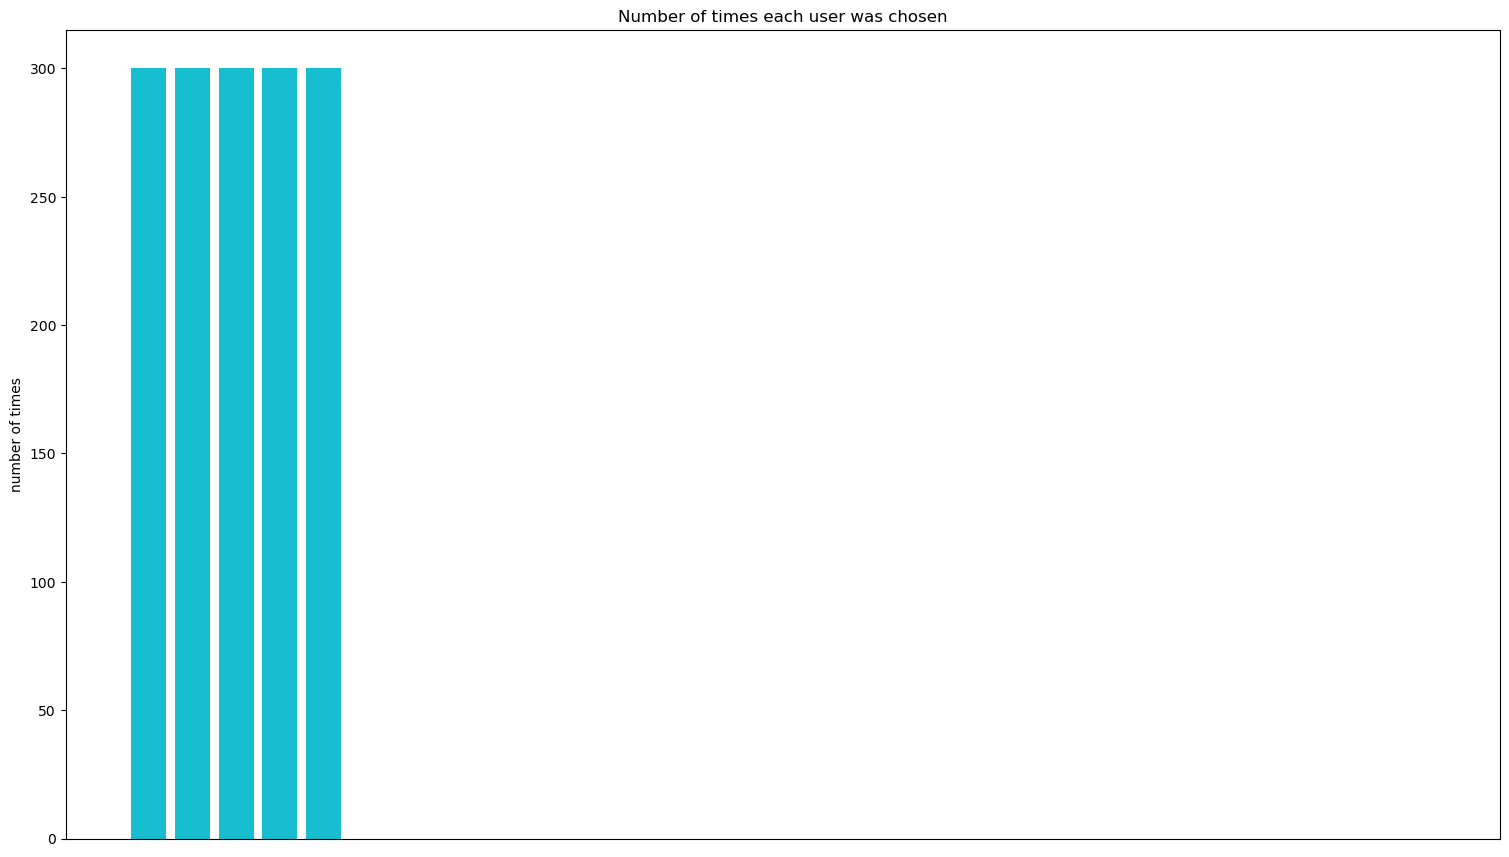

In [90]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
l1_norm_avg_deltha_theta_list = []
global_epochs_time_list = []
privacy_violations_list = []
max_privacy_violation = 0


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        textio.cprint(f"iteration: {global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, global_epoch, textio, method=args.method_choosing_users)

    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    num_slow_users = 0
    num_fast_users = 0
    for usr_idx in sorted(rounds_choise):
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if local_models[usr_idx].privacy_violation > max_privacy_violation:
            max_privacy_violation = local_models[usr_idx].privacy_violation
        if args.choosing_users_verbose:
            textio.cprint(f"user {usr_idx}, emp_avg: {local_models[usr_idx].emp_avg}, h: {local_models[usr_idx].ucb_generalization}, ucb: {local_models[usr_idx].ucb}, num_of_obs(calculated after picking at this round): {local_models[usr_idx].num_of_obs}, privacy reward: {local_models[usr_idx].privacy_reward}, g: {local_models[usr_idx].g}, curr_delay = {local_models[usr_idx].last_access_time}")
        if usr_idx < args.num_users//2:
            num_fast_users += 1
        else:
            num_slow_users += 1
    if args.choosing_users_verbose:
        textio.cprint(f"num of fast users chosen: {num_fast_users}, num of slow users chosen: {num_slow_users}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        textio.cprint(f"max_delay = {max_delay:.2f} seconds")

    privacy_violations_list.append(max_privacy_violation)
    
    
    
    """Part 2: Training"""
    learning_utils.distribute_model(local_models, global_model)
    users_avg_loss_over_local_epochs = []

    for user_idx in rounds_choise:
        user_loss = []
        for local_epoch in range(args.local_epochs):
            user = local_models[user_idx]
            train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
            if args.lr_scheduler:
                user.scheduler.step(train_loss)
            user_loss.append(train_loss)
        users_avg_loss_over_local_epochs.append(mean(user_loss))
    
    avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
    train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)


    avg_deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise, textio
                                                     ,args, snr_verbose = args.snr_verbose)
    # l1_norm_avg_deltha_theta = sum(LA.vector_norm(param.flatten(),1) for param in avg_deltha_theta.values())
    # l1_norm_avg_deltha_theta_list.append(l1_norm_avg_deltha_theta)
    # print(f"l1_norm_avg_deltha_theta is {l1_norm_avg_deltha_theta}")
    

    val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
    val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

    # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
    #                                     "val_loss": val_loss}, time.time()-start_time)
    # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


    time_counter += max_delay
    textio.cprint((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
    global_epochs_time_list.append(time_counter)
    gc.collect()


    if val_acc > best_val_acc and args.save_best_model:
        best_val_acc = val_acc
        torch.save({"model's state dict":global_model.state_dict(),
                    "train_loss_list": train_loss_list,
                    "val_acc_list": val_acc_list,
                    "val_losses_list": val_losses_list,
                    "global_epochs_time_list": global_epochs_time_list,
                    "num_of_users": args.num_users,
                    "num_of_users_per_round": args.num_users_per_round,
                    "privacy_violations_list": privacy_violations_list}
                    , path_best_model)
    
    
    torch.save({"model's state dict":global_model.state_dict(),
                "train_loss_list": train_loss_list,
                "val_acc_list": val_acc_list,
                "val_losses_list": val_losses_list,
                "global_epochs_time_list": global_epochs_time_list,
                "num_of_obs_arr": num_of_obs_arr.reshape(-1),
                "global_epoch": global_epoch,
                "num_of_users": args.num_users,
                "num_of_users_per_round": args.num_users_per_round,
                "privacy_violations_list": privacy_violations_list}
                , last_model_path)
    
    users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
    plt.bar(users_idxs, num_of_obs_arr.reshape(-1))
    plt.title("Number of times each user was chosen")
    plt.ylabel("number of times")
    #hide x labels 
    plt.xticks([])
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    #boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
    plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

    if time_counter > args.max_seconds:
        break



#choices_table = choices_table.cumsum(axis=0)
